In [1]:
# Purpose: Quickly analysing ENSOWind EXP to see if all okay
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                                                                                       
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.path as mpath
import time
import matplotlib.animation as animation # library that makes the movie
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m

#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Comparing the simulated N34 to the events in JRA55-do

In [2]:
# %%time
# # creating my own database
# db = 'local_cc_test.db'
# session = cc.database.create_session(db)
# directory_list=['/scratch/e14/mv7494/access-om2/archive/01deg_jra55_ryf_ENFull', '/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_LNFull']
# cc.database.build_index(directory_list, session)
# # Wall time: 1min 22s (reinitalising from start)

CPU times: user 12.9 s, sys: 4.54 s, total: 17.4 s
Wall time: 40.9 s


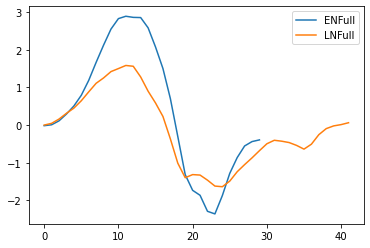

In [3]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
# ---------------------------------------------------------------------------------- #
depth     = [         0]  # 0 = sea surface                                          #
sel_lat   = [1194, 1296]  # 5°S - 5°N                                                #
sel_lon   = [1099, 1600]  # 170°W - 120°W                                            #
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14
        
    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] # string with all file locations
    temp_clim  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[:, depth[0], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    temp       = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).temp[:, depth[0], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    anom       = (temp - temp_clim).mean(['yt_ocean','xt_ocean'])
    if e == 1: N34_EN01_anom = anom.load()
    if e == 2: N34_LN01_anom = anom.load()
plt.plot(N34_EN01_anom, label='ENFull'); plt.plot(N34_LN01_anom, label='LNFull'); plt.legend()
# Walltime: 6.16 s

### Now also loading in the time series from the JRA55-do events

In [4]:
%%time
forcing = '1-3' # 1-4-0                                                                                        #
period = ['1958','2018'] # which period to consider for anomaly calculation                                    #
f11 = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
# remove monthly mean to calculate anomalies
ts = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time')) 
N34_JRA = ts.isel(lon = slice(339,428)).isel(lat = slice(150,169)).mean(['lat','lon']).load() # N34 region: 5°S-5°N and 170°W-120°W -> -5.335°S ... 5.335°S, 190.1°E ... 240.2°E
time = np.linspace(1,30,30) # time axis of idealised time series
time2 = np.linspace(1,24+22,24+24) # time axis of idealised time series

EN_periods = [168,192,288,312,467,491,683,707] # top four El Niño events
LN_periods = [168,216,347,395,468,516,612,660] # top four La Niña events

N34_1972 = N34_JRA.isel(time = slice(EN_periods[0],EN_periods[1]+6)).load() # N34 peak in 1972-12 (index 180) extended by six months
N34_1982 = N34_JRA.isel(time = slice(EN_periods[2],EN_periods[3]+6)).load() # N34 peak in 1982-12 (index 300)
N34_1997 = N34_JRA.isel(time = slice(EN_periods[4],EN_periods[5]+6)).load() # N34 peak in 1997-11 (index 479)
N34_2015 = N34_JRA.isel(time = slice(EN_periods[6],EN_periods[7]+6)).load() # N34 peak in 2015-12 (index 695)

N34_1973 = N34_JRA.isel(time = slice(LN_periods[0],LN_periods[1])).load() # N34 peak in 1972-12 (index 192)
N34_1988 = N34_JRA.isel(time = slice(LN_periods[2],LN_periods[3])).load() # N34 peak in 1984-12 (index 370)
N34_1998 = N34_JRA.isel(time = slice(LN_periods[4],LN_periods[5])).load() # N34 peak in 1997-11 (index 491)
N34_2011 = N34_JRA.isel(time = slice(LN_periods[6],LN_periods[7])).load() # N34 peak in 2015-12 (index 634)
# Wall time: 21.7 s

CPU times: user 30.4 s, sys: 3.54 s, total: 34 s
Wall time: 34.7 s


### Loading in AS/BS temperatures and wind stresses from ENFull/LNFull ACCESS-OM2-01, calculate Ekman transport velocity anomalies
Ekman transport:

$u_E = 1/(\rho \times f) \cdot \tau_y$, $v_E = -1/(\rho \times f) \cdot \tau_x$

CPU times: user 3.48 s, sys: 716 ms, total: 4.2 s
Wall time: 12.2 s


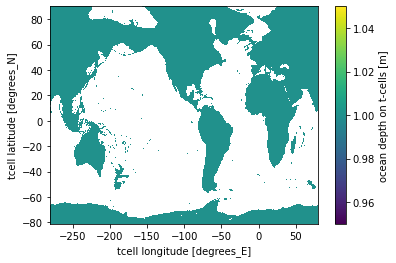

In [5]:
%%time
# first get the shelf mask
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu; above1000 = field.where(field >= 1000,1); above1000_ucells = above1000.where(above1000 < 1000, drop=False) 
# Wall time: 8.74 s
above1000_tcells.plot()

In [6]:
%%time
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
# ---------------------------------------------------------------------------------- #
sel_lat   = [   0,  500]  # 81.1°S - 59.5°S                                          #
sel_lon = [1299, 2200]  # [1299, 2200] = 150°W - 60°W                              #
# ---------------------------------------------------------------------------------- #
for b in range(2): # loop through the budgets for surface - 1000 m and 100 - 1000 m
    if b == 0: print('Calculating surface - 1000 m anoms'); depth = [ 0, 47] # surface - 1017 m
    if b == 1: print('Calculating     100 - 1000 m anoms'); depth = [23, 47] # 97.6 - 1017 m

    for e in [1,2]: # loop through the two simulations ENFull and LNFull
        print(exp[e])
        if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
        if e == 2: last_output = 989; nr_outputs = 14

        a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
        s = list(range(0,nr_outputs))
        c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
        for i in s: # loop through the number of files I would like
            # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
            c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
            d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

            t.append(i); t[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
            u.append(i); u[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
            
            q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]         
        average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 # average time in seconds per month (the output is saved in ns, that's why /1e9) 

        temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).temp[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
        temp        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).temp[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
        
        wt_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).wt[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
        wt        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).wt[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

        # the same now for the winds stress I need to calculate Ekman transport anomalies
        taux_clim  = xr.open_mfdataset(t,combine='by_coords',chunks={'time': 1},decode_times = True).tau_x[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] * above1000_ucells
        taux       = xr.open_mfdataset(u,combine='by_coords',chunks={'time': 1},decode_times = True).tau_x[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] * above1000_ucells
        tauy_clim  = xr.open_mfdataset(t,combine='by_coords',chunks={'time': 1},decode_times = True).tau_y[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] * above1000_ucells
        tauy       = xr.open_mfdataset(u,combine='by_coords',chunks={'time': 1},decode_times = True).tau_y[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] * above1000_ucells

        if e == 1: 
            anom_EN_WA              = ((temp - temp_clim)*above1000_tcells)[:, depth[0]:depth[1], :, :].mean(['st_ocean', 'xt_ocean', 'yt_ocean']).load()
            temp_EN_anom_full_depth = (temp - temp_clim)
            wt_EN_anom_full_depth   = (wt   - wt_clim)
            tau_x_EN_anom           = (taux - taux_clim); tau_y_EN_anom = (tauy - tauy_clim)
        if e == 2: 
            anom_LN_WA              = ((temp - temp_clim)*above1000_tcells)[:, depth[0]:depth[1], :, :].mean(['st_ocean', 'xt_ocean', 'yt_ocean']).load()
            temp_LN_anom_full_depth = (temp - temp_clim)
            wt_LN_anom_full_depth   = (wt   - wt_clim)
            tau_x_LN_anom           = (taux - taux_clim); tau_y_LN_anom = (tauy - tauy_clim)        
     
    if b == 0: 
        anom_EN_WA_sfc1000 = anom_EN_WA # save temperature anomalies for surface down to 1000 m
        anom_LN_WA_sfc1000 = anom_LN_WA  
    if b == 1: 
        anom_EN_WA_1001000 = anom_EN_WA # save temperature anomalies for 100 m down to 1000 m
        anom_LN_WA_1001000 = anom_LN_WA     
    print('----------------------------------')
# Wall time: 30.4 s

Calculating surface - 1000 m anoms
01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
Calculating     100 - 1000 m anoms
01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 1min 2s, sys: 6.25 s, total: 1min 8s
Wall time: 2min 29s


Text(0.5, 1.0, 'Cumulative mean temp anom 100-shelf bottom')

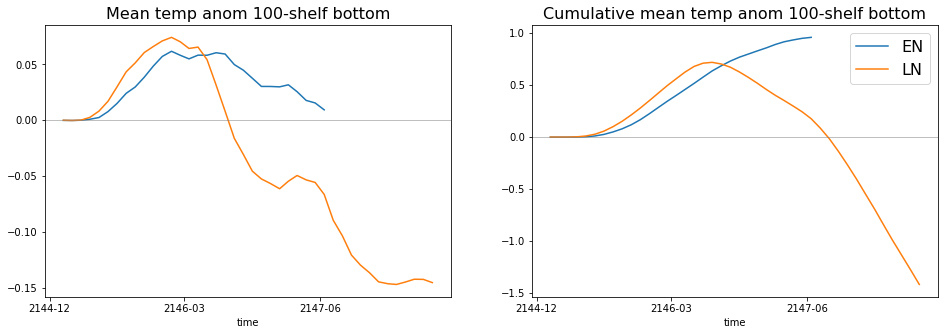

In [7]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1); anom_EN_WA_1001000.plot(label='EN'); anom_LN_WA_1001000.plot(label='LN')
plt.axhline(0, c='grey', linewidth=.5); plt.title('Mean temp anom 100-shelf bottom', fontsize=16)
plt.subplot(1,2,2); anom_EN_WA_1001000.cumsum('time').plot(label='EN'); anom_LN_WA_1001000.cumsum('time').plot(label='LN')
plt.axhline(0, c='grey', linewidth=.5); plt.legend(fontsize=16); plt.title('Cumulative mean temp anom 100-shelf bottom', fontsize=16)

### Calculate the vertical heat flux + uncertainty

In [8]:
%%time
# first, get climatological shelf temperature range in °C
clim = ((temp_clim*above1000_tcells[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]).mean('time') - 273.15).load()
clim_range = np.nanpercentile(clim, 84.1) - np.nanpercentile(clim, 15.9)
clim_range # the temperature range in the interquartile range, excluding those few ones with very low/high temperatures
# Wall time: 48.6 s

CPU times: user 3.71 s, sys: 1.21 s, total: 4.91 s
Wall time: 23.8 s


2.23455810546875

In [9]:
[np.nanpercentile(clim, 84.1), np.nanpercentile(clim, 15.9)]

[0.602386474609375, -1.632171630859375]

In [10]:
# clim1 = ((temp_clim*above1000_tcells[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]).mean('time')[depth[0],:,:] - 273.15).load()
# clim2 = (temp_clim.mean('time')[depth[0]:depth[1]]*above1000_tcells-273.15)[:,:,0]
# clim3 = (temp_clim.mean('time')[depth[0]:depth[1]]*above1000_tcells-273.15)[:,394:,-1]
# clim_range = np.nanpercentile((clim1+clim2+clim3), 84.1) - np.nanpercentile((clim1+clim2+clim3), 15.9)
# clim_range # the temperature range in the interquartile range, excluding those few ones with very low/high temperatures
# # Wall time: 48.6 s

In [11]:
%%time
# get the grid cell area and ocean depth, select West Antarctic shelf region and interpolate to dTdz grid
base_grid = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean'
rho_0 = 1035.0                       # [kg m^{-3}]
C_p   = 3992.10322329649               # [J kg^{-1} K^{-1}]
area_t = xr.open_mfdataset(base_grid+'_grid.nc').area_t[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
dyt    = xr.open_mfdataset(base_grid+'_grid.nc').dyt[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
above1000 = above1000_tcells[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

for f in range(2):
    if f == 0: wt_anom = wt_EN_anom_full_depth; temp_anom = temp_EN_anom_full_depth
    if f == 1: wt_anom = wt_LN_anom_full_depth; temp_anom = temp_LN_anom_full_depth
    
    # here the calculation of the vertical heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) --------------------------------------------------- #
    vertical_heat_flux = (rho_0 * C_p * wt_anom[:,23,:,:] * temp_anom[:,23,:,:] * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']).load()
    # and now also the uncertainties - clim_range = (\Delta\Theta)^{max} = 2.39°C 
    vertical_heat_flux_uncertainty = (rho_0 * C_p * wt_anom[:,23,:,:] * clim_range / 2 * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']).load()
    
    if f == 0: vertical_heat_flux_EN = -vertical_heat_flux; vertical_heat_flux_uncertainty_EN = -vertical_heat_flux_uncertainty # z index increases downwards, so flip the order here.
    if f == 1: vertical_heat_flux_LN = -vertical_heat_flux; vertical_heat_flux_uncertainty_LN = -vertical_heat_flux_uncertainty
# Wall time: 59 s

CPU times: user 17.4 s, sys: 2.61 s, total: 20 s
Wall time: 1min 28s


### Quick check how much the x transports are across 150°W and 60°W on the shelf

In [12]:
%%time
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
dzt = xr.open_mfdataset(base_grid+'.nc').dzt[0,depth[0]:depth[1]:,sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

# ---------------------------------------------------------------------------------- #
depth = [23, 47] # 97.6 - 1017 m
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

    u_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).u[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    u        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).u[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    if e == 1: 
        u_EN_anom_full_depth   = (u   - u_clim) * above1000_ucells[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    if e == 2: 
        u_LN_anom_full_depth   = (u   - u_clim) * above1000_ucells[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]  
print('----------------------------------')
# Wall time: 30.4 s

01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 5.69 s, sys: 542 ms, total: 6.23 s
Wall time: 6.39 s


In [13]:
%%time
# temperature ranges in both transects 150°W and 60°W
clim = (temp_clim.mean('time')[depth[0]:depth[1]]*above1000_tcells-273.15)[:,:,0]
clim_range1 = np.nanpercentile(clim, 84.1) - np.nanpercentile(clim, 15.9)
clim = (temp_clim.mean('time')[depth[0]:depth[1]]*above1000_tcells-273.15)[:,394:,-1]
clim_range2 = np.nanpercentile(clim, 84.1) - np.nanpercentile(clim, 15.9)

for f in range(2):
    print(exp[f+1])
    if f == 0: u_anom = u_EN_anom_full_depth; temp_anom = temp_EN_anom_full_depth
    if f == 1: u_anom = u_LN_anom_full_depth; temp_anom = temp_LN_anom_full_depth

    # here the calculation of the horizontal heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m * m * s) = (J) --------------------------------------------------- #
    along_shelf_heat_flux = (rho_0 * C_p * (
        ((u_anom[:,depth[0]:depth[1],:,0])).interp(yu_ocean = temp_anom.yt_ocean.values, method="nearest").rename({'yu_ocean': 'yt_ocean'})) * (
        (temp_anom[:,depth[0]:depth[1],:,:] * above1000_tcells)[:,:,:,0]) * (
        (dzt * dyt * above1000_tcells)[:,:,0]) * ( # multiply with depth * latitude length
        average_DT)).sum(['st_ocean', 'yt_ocean']) + (
        (rho_0 * C_p * (
        ((u_anom[:,depth[0]:depth[1],394:,0])).interp(yu_ocean = temp_anom.yt_ocean.values, method="nearest").rename({'yu_ocean': 'yt_ocean'})) * (
        (temp_anom[:,depth[0]:depth[1],394,:] * above1000_tcells)[:,:,394,0]) * (
        (dzt * dyt * above1000_tcells)[:,394,0]) * ( # multiply with depth * latitude length
        average_DT)).sum(['st_ocean', 'yt_ocean'])).load()
    print('along_shelf_heat_flux done')
    
    # and now the uncertainty in the horizontal heat fluxes --------------------------------------------------------------------------------------------------- #
    along_shelf_heat_flux_uncertainty = (rho_0 * C_p * (
        ((u_anom[:,depth[0]:depth[1],:,0])).interp(yu_ocean = temp_anom.yt_ocean.values, method="nearest").rename({'yu_ocean': 'yt_ocean'})) * (
        clim_range / 2) * (
        (dzt * dyt * above1000_tcells)[:,:,0]) * ( # multiply with depth * latitude length
        average_DT)).sum(['st_ocean', 'yt_ocean']) + (
        (rho_0 * C_p * (
        ((u_anom[:,depth[0]:depth[1],394:,0])).interp(yu_ocean = temp_anom.yt_ocean.values, method="nearest").rename({'yu_ocean': 'yt_ocean'})) * (
        clim_range / 2) * (
        (dzt * dyt * above1000_tcells)[:,394,0]) * ( # multiply with depth * latitude length
        average_DT)).sum(['st_ocean', 'yt_ocean'])).load()
    print('along_shelf_heat_flux_uncertainty done')
    print('--------------------------------------')
    if f == 0: along_shelf_heat_flux_EN = along_shelf_heat_flux.load(); along_shelf_heat_flux_uncertainty_EN = along_shelf_heat_flux_uncertainty.load()
    if f == 1: along_shelf_heat_flux_LN = along_shelf_heat_flux.load(); along_shelf_heat_flux_uncertainty_LN = along_shelf_heat_flux_uncertainty.load()
# Wall time: 1min 7s

01deg_jra55_ryf_ENFull
along_shelf_heat_flux done
along_shelf_heat_flux_uncertainty done
--------------------------------------
01deg_jra55_ryf_LNFull
along_shelf_heat_flux done
along_shelf_heat_flux_uncertainty done
--------------------------------------
CPU times: user 25.4 s, sys: 4.23 s, total: 29.7 s
Wall time: 2min 27s


### Load in temperature and wind stress data from the idealised simulations

In [14]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
# --------------------------------------------------------------------------------- #
depth     = [  23,   47]   # [   23,   47] = 97.6 m - 1017 m                        #
sel_lat   = [  0,  500]   # [  26,  529]  = 80.01°S - 58.04°S                      #
sel_lon   = [1299, 2200]  # 150°W - 60°W                                            #
# --------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

    tau_x_clim = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).tau_x
    tau_y_clim = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).tau_y
    
    tau_x      = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).tau_x
    tau_y      = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).tau_y

    if e == 1: 
        tau_x_EN_anom = ((tau_x - tau_x_clim)).load()
        tau_y_EN_anom = ((tau_y - tau_y_clim)).load()
    if e == 2:
        tau_x_LN_anom = ((tau_x - tau_x_clim)).load()
        tau_y_LN_anom = ((tau_y - tau_y_clim)).load()
    print('----------------------')
# Wall time: 46.2 s

01deg_jra55_ryf_ENFull
----------------------
01deg_jra55_ryf_LNFull
----------------------
CPU times: user 24.2 s, sys: 15.6 s, total: 39.8 s
Wall time: 55.1 s


### Calculating Ekman transport on the shelf
- Ekman pumping velocity

$w_E = \frac{1}{\rho f}\big(\frac{\partial \tau_y}{\partial x} + \frac{\partial \tau_x}{\partial y}\big)$

CPU times: user 2.04 s, sys: 593 ms, total: 2.63 s
Wall time: 3.25 s


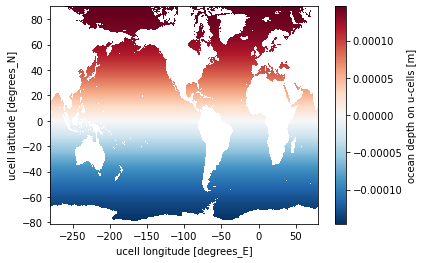

In [15]:
%%time
# calculating f
lat = tau_x_EN_anom.yu_ocean.values
rho_0 = 1035.0                       # [kg m^{-3}]
C_p   = 3992.10322329649               # [J kg^{-1} K^{-1}]
coriolis = 2 * 7.292e-5 * np.sin(lat * np.pi/180) # s^{-1}
dxu = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc').dxu
dyu = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc').dyu

aa, bb = np.meshgrid(tau_x_EN_anom.xu_ocean.values,coriolis) # create meshgrid

field = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc').hu
ht = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc').ht
field = field.fillna(0) # replace all nan with zeroes
landsea_mask = field.where(field>=0,1).where(field<=0,1).where(field !=0) # replace all non-zero data with ones and all zeros with np.nan
coriolis = (bb*landsea_mask)
(coriolis).plot(cmap='RdBu_r') # ok, this is the Coriolis parameter for ever grid cell
# Wall time: 2.74 s

Ekman transport velocities:

$u_E = \frac{1}{\rho_0 \cdot f} \cdot \tau_y$

$v_E = -\frac{1}{\rho_0 \cdot f} \cdot \tau_x$

### Load in 1000 m isobath cross-shelf transport masks and calculate Ekman transport anomalies
Created with the script "Cross-contour_transport.ipynb" that is based on Claire Yung's COSIMA cookbook code on https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Cross-contour_transport.html

CPU times: user 479 ms, sys: 87.2 ms, total: 567 ms
Wall time: 591 ms


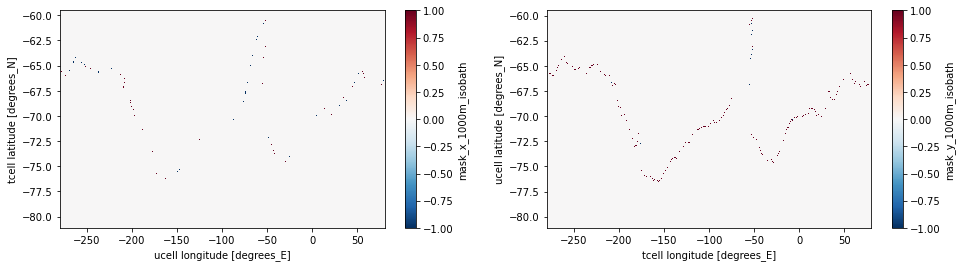

In [16]:
%%time
# save masks for both x transport and y transport as netcdf file
mask_x_transport_ucells = xr.open_dataset('/g/data/e14/mv7494/ACCESS-OM2-01_transport_masks/mask_x_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_x_1000m_isobath
mask_y_transport_ucells = xr.open_dataset('/g/data/e14/mv7494/ACCESS-OM2-01_transport_masks/mask_y_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_y_1000m_isobath
plt.figure(figsize=(16,4)); plt.subplot(1,2,1); mask_x_transport_ucells.plot(); plt.subplot(1,2,2); mask_y_transport_ucells.plot()

CPU times: user 67.7 ms, sys: 42.7 ms, total: 110 ms
Wall time: 123 ms


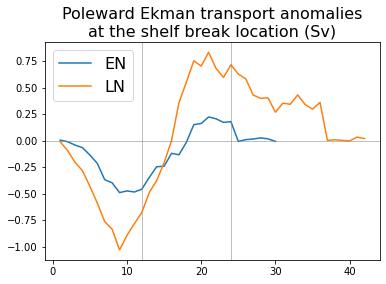

In [17]:
%%time
poleward_Ekman_EN = xr.open_dataset('/home/561/mv7494/'+'Fig3_Heat_Content_Ekman_anoms_and_Heat_Budget_Time_series_EN.nc').Poleward_Ekman_anoms
poleward_Ekman_LN = xr.open_dataset('/home/561/mv7494/'+'Fig3_Heat_Content_Ekman_anoms_and_Heat_Budget_Time_series_LN.nc').Poleward_Ekman_anoms

# for f in [1,2]: # loop through both El Niño and La Niña simulations
#     print(exp[f])
#     if f == 1:
#         tau_x = tau_x_EN_anom
#         tau_y = tau_y_EN_anom
#     if f == 2:
#         tau_x = tau_x_LN_anom
#         tau_y = tau_y_LN_anom
#     # --------------------------------------------------------------------------------------------------------------------------------------------------------- #
#     u_E = ( (1 / (rho_0 * coriolis)) * tau_y * dyu).rename({'yu_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})[0:500,:,:]                                           #
#     v_E = (-(1 / (rho_0 * coriolis)) * tau_x * dxu).rename({'yu_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})[0:500,:,:]                                           #
    
#     # interpolate onto the correct grid
#     u_E = u_E.interp(y_ocean=mask_x_transport_ucells.y_ocean.values,method='nearest')*mask_x_transport_ucells
#     v_E = v_E.interp(x_ocean=mask_y_transport_ucells.x_ocean.values,method='nearest')*mask_y_transport_ucells

#     # --------------------------------------------------------------------------------------------------------------------------------------------------------- #
#     # multiply Ekman velocities with shelf mask, convert to units of Sv, multiply with -1 to define poleward (southward) transport as positive instead of       #
#     # northward transport as positive, take the sum over the contour (one grid cell in y-direction) & take the sum over the West Antarctic (150°W-60°W) region  #
#     poleward_Ekman = ((u_E * mask_x_transport_ucells + v_E * mask_y_transport_ucells) / 1e6 * -1)[:,sel_lon[0]:sel_lon[1],:].sum(['y_ocean', 'x_ocean']).load() #
#     # --------------------------------------------------------------------------------------------------------------------------------------------------------- #
#     if f == 1: poleward_Ekman_EN = poleward_Ekman
#     if f == 2: poleward_Ekman_LN = poleward_Ekman
#     print('----------------------')

time_EN = np.linspace(1,30,30)
time_LN = np.linspace(1,42,42)
plt.plot(time_EN, poleward_Ekman_EN, label='EN'); plt.axvline(12, linewidth=.5, c='grey'); plt.plot(time_LN, poleward_Ekman_LN, label='LN'); plt.axvline(24, linewidth=.5, c='grey')
plt.title('Poleward Ekman transport anomalies\nat the shelf break location (Sv)', fontsize='16'); plt.legend(fontsize=16); plt.axhline(0, linewidth=.5, c='grey')
# Wall time: 18.5 s

### Calculating Ekman pumping
$w_{e}$ = $\frac{1}{\rho_0 \cdot f}$ $(-\frac{\partial \tau_y}{\partial x}$ + $\frac{\partial \tau_x}{\partial y})$

temp_adv_vert = $w_e \cdot \frac{\partial \Theta}{\partial z} \cdot \rho_0 \cdot C_p \cdot h$

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 18.4 s, sys: 10.4 s, total: 28.9 s
Wall time: 54.1 s


Text(0.5, 1.0, 'Vert. heat flux across 100 m (J)')

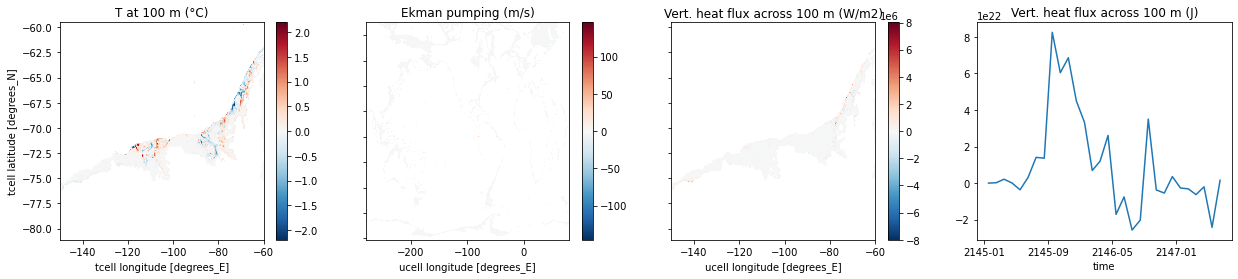

In [18]:
%%time

# get the grid cell area and ocean depth, select West Antarctic shelf region and interpolate to dTdz grid
base_grid = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean'

dTdz = (temp_EN_anom_full_depth.differentiate('st_ocean') * above1000_tcells).rename({'yt_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})
T = (temp_EN_anom_full_depth * above1000_tcells).rename({'yt_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})
w_e = (1 / (rho_0 * coriolis)) * (tau_y_EN_anom.differentiate('xu_ocean') - tau_x_EN_anom.differentiate('yu_ocean')) * above1000_ucells
w_e_interp = w_e.interp(yu_ocean = T.y_ocean.values, xu_ocean = T.x_ocean.values).rename({'yu_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'}) # next, I need to interpolate this onto the t-cell grid


area_t = xr.open_mfdataset(base_grid+'_grid.nc').area_t[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].rename({'yt_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'}).interp(y_ocean = dTdz.y_ocean.values, x_ocean = dTdz.x_ocean.values)
dzt = xr.open_mfdataset(base_grid+'.nc').dzt[0,23,sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].rename({'yt_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'}).interp(y_ocean = dTdz.y_ocean.values, x_ocean = dTdz.x_ocean.values)

temp_adv_vert = (w_e_interp*T*rho_0*C_p)

plt.figure(figsize=(21,4));
ax1 = plt.subplot(1,4,1); T[11,23,:,:].plot(); plt.title('T at 100 m (°C)')
ax1 = plt.subplot(1,4,2); w_e[:,:,11].plot(); plt.title('Ekman pumping (m/s)'); ax1.set_yticklabels([]); ax1.set(ylabel=None) 
ax1 = plt.subplot(1,4,3); temp_adv_vert[:,:,11,23].plot(); plt.title('Vert. heat flux across 100 m (W/m2)'); ax1.set_yticklabels([]); ax1.set(ylabel=None) 
ax1 = plt.subplot(1,4,4); (temp_adv_vert*area_t*average_DT)[:,:,:,23].sum(['y_ocean', 'x_ocean']).plot(); plt.title('Vert. heat flux across 100 m (J)')
# Wall time: 25.6 s

### Next step, calculating the cross-shelf heat fluxes

In [19]:
%%time
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
# ---------------------------------------------------------------------------------- #
sel_lat   = [   0,  500]  # 81.1°S - 59.5°S                                          #
sel_lon = [1299, 2200]  # [1299, 2200] = 150°W - 60°W                              #
# ---------------------------------------------------------------------------------- #

for e in [1]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

        t.append(i); t[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
        u.append(i); u[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'

        q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]         
    average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 # average time in seconds per month (the output is saved in ns, that's why /1e9) 

    temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    temp        = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).temp[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    # the same now for the volume fluxes across transects
    tx_trans_clim         = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).tx_trans[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    # tx_trans_submeso_clim = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).tx_trans_submeso[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    tx_trans              = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tx_trans[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    # tx_trans_submeso      = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tx_trans_submeso[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets

    ty_trans_clim         = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).ty_trans[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    # ty_trans_submeso_clim = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).ty_trans_submeso[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    ty_trans              = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).ty_trans[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    # ty_trans_submeso      = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).ty_trans_submeso[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets

    if e == 1: 
        temp_EN_anom     = (temp - temp_clim)
        tx_trans_EN_anom = (tx_trans - tx_trans_clim); ty_trans_EN_anom = (ty_trans - ty_trans_clim)
    if e == 2: 
        temp_LN_anom     = (temp - temp_clim)
        tx_trans_LN_anom = (tx_trans - tx_trans_clim); ty_trans_LN_anom = (ty_trans - ty_trans_clim)     

dyt = xr.open_mfdataset(base_grid+'_grid.nc').dyt
print('----------------------------------')
# Wall time: 30.4 s

01deg_jra55_ryf_ENFull
----------------------------------
CPU times: user 6.58 s, sys: 874 ms, total: 7.45 s
Wall time: 6.89 s


In [20]:
# mask_x_transport_tcells = xr.open_dataset('/g/data/e14/mv7494/mask_x_transport_tcells_1000m_isobath_ACCESS-OM2-01.nc').mask_x_1000m_isobath.rename({'y_ocean': 'yt_ocean', 'x_ocean': 'xt_ocean'})
# mask_y_transport_tcells = xr.open_dataset('/g/data/e14/mv7494/mask_y_transport_tcells_1000m_isobath_ACCESS-OM2-01.nc').mask_y_1000m_isobath.rename({'y_ocean': 'yt_ocean', 'x_ocean': 'xt_ocean'})
# mask_y_transport_tcells = mask_y_transport_tcells[:425,sel_lon[0]:sel_lon[1]]
# mask_y_transport_tcells

### Calculating the heat budget anomalies

In [21]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc', 'ocean_heat.nc']


# base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
# exp    = ['025deg_jra55_ryf_ENControl','025deg_jra55_ryf_ENFull', '025deg_jra55_ryf_LNFull']
# region = ['Amundsen Sea', 'Bellingshausen Sea', 'West Antarctica']


# ----------------------------------------------------------------------------------------------------------------------------- #
# depth     = [  23,   47]  # [ 23,   47] = 97.6 m - 1017 m, [24,   40] = 108.9 - 517.6 m                                       #
sel_lat   = [   0,  400]  # [120,  263] = 76.03°S - 70.04°S                                                                     #
# ----------------------------------------------------------------------------------------------------------------------------- #
rho_0     = 1035          # reference density [1035 kg * m^-3]                                                                  #
C_p       = 3992.1        # reference specific heat capacity [3992.1 J * kg^-1 * K^-1]                                          #
area_t      = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').area_t[                                        #
              sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]                                                                     #
# area_t      = xr.open_mfdataset(base[0]+exp[0]+'/output325/ocean/ocean_grid.nc').area_t[
#               sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] 
dyt  = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').dyt[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]     #

var  = ['temp_submeso',                                                                                                         #
        'temp_tendency',                                                                                # ocean heat tendency   #
        'temp_advection',                                                                               # advection terms       #
        'temp_vdiffuse_diff_cbt', 'temp_nonlocal_KPP',                                                  # vertical mixing terms #
        'sw_heat', 'temp_vdiffuse_sbc', 'sfc_hflux_pme',                                                # surface forcing terms #
        'frazil_3d', 'temp_eta_smooth',                                                                 # surface heat fluxes   #
        'temp_rivermix']                                                                                # surface volume flux   #
# variables in temperature space                                                                                                #
var2 = ['tx_trans_nrho', 'ty_trans_nrho',                                                               # advection terms       #
        'mass_pmepr_on_nrho',                                                                           # surface volume flux   #
        'temp_vdiffuse_diff_cbt_on_nrho', 'temp_nonlocal_KPP_on_nrho',                                  # vertical mixing terms #
        'temp_vdiffuse_sbc_on_nrho', 'sw_heat_on_nrho', 'frazil_on_nrho', 'temp_eta_smooth_on_nrho']    # surface forcing terms #
# ----------------------------------------------------------------------------------------------------------------------------- #

for h in range(2):
    if h == 0: depth = [ 0, 47]; print('Calculating OHC budget for surface - 1000 m')
    if h == 1: depth = [23, 47]; print('Calculating OHC budget for 100 - 1000 m')
    dzt   = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_month.nc').dzt[0,depth[0]:depth[1],sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]  #

    for e in [1,2]: # loop through the two simulations ENFull and LNFull
        print('Loading in '+ exp[e] + ' for the Eulerian heat budget:')
        print('---------------------------------------------------------------')

        if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
        if e == 2: last_output = 989; nr_outputs = 14

        a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
        s = list(range(0,nr_outputs))
        c = []; d = []; f = []; g = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
        for i in s: # loop through the number of files I would like
            # fill in empty list with integers trailing two zeros (000, 001, 002, ...)       
            f.append(i); f[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[3] # string with all file locations
            g.append(i); g[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[3]         
            
        for v in range(len(var)): # loop through the eight diagnostics I need to balance the heat budget
            print(var[v])
            if v in [0, 1, 2, 3, 4, 5, 6, 8, 10]:
                variable_clim = xr.open_mfdataset(f,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
                variable      = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

            if v in [7, 9]: # these two fields (sfc_hflux_pme & temp_eta_smooth) are only 3D (time, latitude, longitude)
                variable_clim = xr.open_mfdataset(f,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
                variable      = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]  

            # -------------------------------------------------------------------------------------- #
            variable = ((variable - variable_clim) * above1000_tcells * area_t) # calculate anomalies by removing the control and multiply with shelf mask
            # -------------------------------------------------------------------------------------- #

            if v ==  0: temp_submeso           = (variable * average_DT).sum(['yt_ocean', 'xt_ocean', 'st_ocean']).load() # calculate time series for each flux
            if v ==  1: temp_tendency          = (variable * average_DT).sum(['yt_ocean', 'xt_ocean', 'st_ocean']).load()
            if v ==  2: temp_advection         = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  3: temp_vdiffuse_diff_cbt = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  4: temp_nonlocal_KPP      = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  5: sw_heat                = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  6: temp_vdiffuse_sbc      = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  7: sfc_hflux_pme          = (variable * average_DT).sum(['yt_ocean', 'xt_ocean']).load()
            if v ==  8: frazil_3d              = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  9: temp_eta_smooth        = (variable * average_DT).sum(['yt_ocean', 'xt_ocean']).load()
            if v == 10: temp_rivermix          = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()         

        if h == 0 and e == 1:
            temp_submeso_EN_sfc_down           = temp_submeso
            temp_tendency_EN_sfc_down          = temp_tendency
            temp_advection_EN_sfc_down         = temp_advection
            temp_vdiffuse_diff_cbt_EN_sfc_down = temp_vdiffuse_diff_cbt
            temp_nonlocal_KPP_EN_sfc_down      = temp_nonlocal_KPP
            sw_heat_EN_sfc_down                = sw_heat
            temp_vdiffuse_sbc_EN_sfc_down      = temp_vdiffuse_sbc
            sfc_hflux_pme_EN_sfc_down          = sfc_hflux_pme;
            frazil_3d_EN_sfc_down              = frazil_3d
            temp_eta_smooth_EN_sfc_down        = temp_eta_smooth
            temp_rivermix_EN_sfc_down          = temp_rivermix
        if h == 1 and e == 1:
            temp_submeso_EN_100_down           = temp_submeso
            temp_tendency_EN_100_down          = temp_tendency
            temp_advection_EN_100_down         = temp_advection
            temp_vdiffuse_diff_cbt_EN_100_down = temp_vdiffuse_diff_cbt
            temp_nonlocal_KPP_EN_100_down      = temp_nonlocal_KPP
            sw_heat_EN_100_down                = sw_heat
            temp_vdiffuse_sbc_EN_100_down      = temp_vdiffuse_sbc
            sfc_hflux_pme_EN_100_down          = sfc_hflux_pme;
            frazil_3d_EN_100_down              = frazil_3d
            temp_eta_smooth_EN_100_down        = temp_eta_smooth
            temp_rivermix_EN_100_down          = temp_rivermix
        if h == 0 and e == 2:
            temp_submeso_LN_sfc_down           = temp_submeso
            temp_tendency_LN_sfc_down          = temp_tendency
            temp_advection_LN_sfc_down         = temp_advection
            temp_vdiffuse_diff_cbt_LN_sfc_down = temp_vdiffuse_diff_cbt
            temp_nonlocal_KPP_LN_sfc_down      = temp_nonlocal_KPP
            sw_heat_LN_sfc_down                = sw_heat
            temp_vdiffuse_sbc_LN_sfc_down      = temp_vdiffuse_sbc
            sfc_hflux_pme_LN_sfc_down          = sfc_hflux_pme;
            frazil_3d_LN_sfc_down              = frazil_3d
            temp_eta_smooth_LN_sfc_down        = temp_eta_smooth
            temp_rivermix_LN_sfc_down          = temp_rivermix
        if h == 1 and e == 2:
            temp_submeso_LN_100_down           = temp_submeso
            temp_tendency_LN_100_down          = temp_tendency
            temp_advection_LN_100_down         = temp_advection
            temp_vdiffuse_diff_cbt_LN_100_down = temp_vdiffuse_diff_cbt
            temp_nonlocal_KPP_LN_100_down      = temp_nonlocal_KPP
            sw_heat_LN_100_down                = sw_heat
            temp_vdiffuse_sbc_LN_100_down      = temp_vdiffuse_sbc
            sfc_hflux_pme_LN_100_down          = sfc_hflux_pme;
            frazil_3d_LN_100_down              = frazil_3d
            temp_eta_smooth_LN_100_down        = temp_eta_smooth
            temp_rivermix_LN_100_down          = temp_rivermix
        print('---------------------------------------------------------------')
# Wall time: 5 min 58s

Calculating OHC budget for surface - 1000 m
Loading in 01deg_jra55_ryf_ENFull for the Eulerian heat budget:
---------------------------------------------------------------
temp_submeso
temp_tendency
temp_advection
temp_vdiffuse_diff_cbt
temp_nonlocal_KPP
sw_heat
temp_vdiffuse_sbc
sfc_hflux_pme
frazil_3d
temp_eta_smooth
temp_rivermix
---------------------------------------------------------------
Loading in 01deg_jra55_ryf_LNFull for the Eulerian heat budget:
---------------------------------------------------------------
temp_submeso
temp_tendency
temp_advection
temp_vdiffuse_diff_cbt
temp_nonlocal_KPP
sw_heat
temp_vdiffuse_sbc
sfc_hflux_pme
frazil_3d
temp_eta_smooth
temp_rivermix
---------------------------------------------------------------
Calculating OHC budget for 100 - 1000 m
Loading in 01deg_jra55_ryf_ENFull for the Eulerian heat budget:
---------------------------------------------------------------
temp_submeso
temp_tendency
temp_advection
temp_vdiffuse_diff_cbt
temp_nonlocal

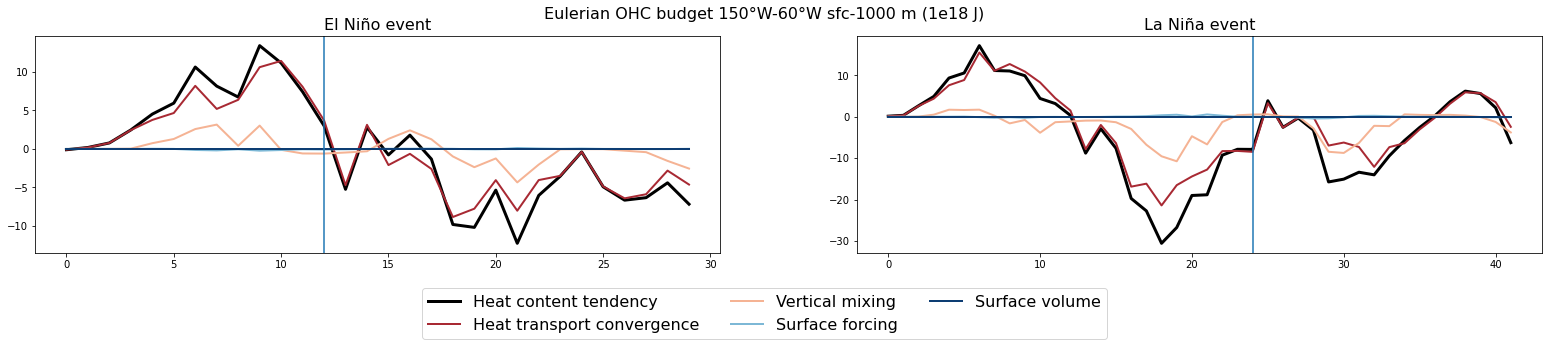

In [22]:
fig = plt.figure(figsize=(27,4)); plt.suptitle('Eulerian OHC budget 150°W-60°W sfc-1000 m (1e18 J)', fontsize=16)
ax1 = plt.subplot(1,2,1); plt.title('El Niño event', fontsize=16)
plt.plot(temp_tendency_EN_100_down/1e18,                                                               label = 'Heat content tendency',      linewidth = 3, color = 'k')
plt.plot(temp_advection_EN_100_down/1e18,                                                              label = 'Heat transport convergence', linewidth = 2, color = rotblau[3])
plt.plot((temp_vdiffuse_diff_cbt_EN_100_down+temp_nonlocal_KPP_EN_100_down)/1e18,                      label = 'Vertical mixing',            linewidth = 2, color = rotblau[7])
plt.plot((temp_submeso_EN_100_down+temp_vdiffuse_sbc_EN_100_down+sw_heat_EN_100_down+temp_eta_smooth_EN_100_down+frazil_3d_EN_100_down)/1e18, label = 'Surface forcing',            linewidth = 2, color = rotblau[14])
plt.plot(temp_rivermix_EN_100_down/1e18,                                                               label = 'Surface volume',             linewidth = 2, color = rotblau[19])
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=16, ncol=3, bbox_to_anchor=(.5, -.2), loc='lower center')
plt.axvline(12);

ax1 = plt.subplot(1,2,2); plt.title('La Niña event', fontsize=16)
plt.plot(temp_tendency_LN_100_down/1e18,                                                               linewidth = 3, color = 'k')
plt.plot(temp_advection_LN_100_down/1e18,                                                              linewidth = 2, color = rotblau[3])
plt.plot((temp_vdiffuse_diff_cbt_LN_100_down+temp_nonlocal_KPP_LN_100_down)/1e18,                               linewidth = 2, color = rotblau[7])
plt.plot((temp_submeso_LN_100_down+temp_vdiffuse_sbc_LN_100_down+sw_heat_LN_100_down+temp_eta_smooth_LN_100_down+frazil_3d_LN_100_down)/1e18, linewidth = 2, color = rotblau[14])
plt.plot(temp_rivermix_LN_100_down/1e18,                                                               linewidth = 2, color = rotblau[19])
plt.axvline(24)

CPU times: user 1.84 s, sys: 247 ms, total: 2.08 s
Wall time: 2.05 s


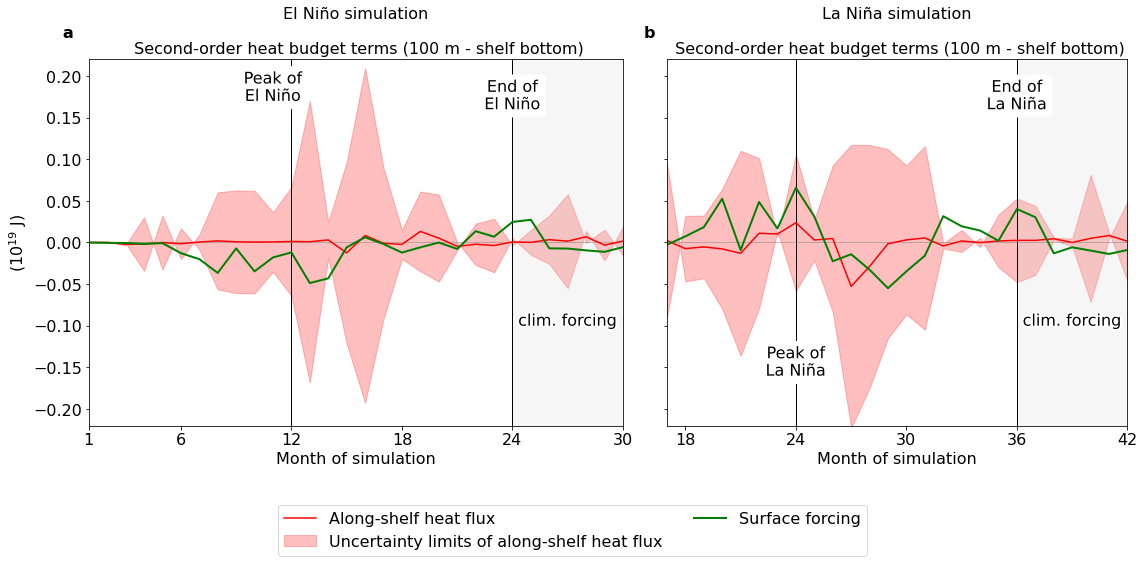

In [23]:
%%time
filename= 'Comparison_simulated_N34_and_JRA55-do'

# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(16,12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,2, width_ratios=[29,25], height_ratios=[1,1,2,6]) 
event = ['El Niño', 'La Niña']
      
for f in [6,7]:


    # simulated heat budget terms
    # ------------------------------------------------------------------- #         
    if f == 6:
        ax1 = plt.subplot(gs[3,0]); plt.axvline(12, c = 'k', linewidth=1); plt.axvline(24, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'El Niño simulation\n\n Second-order heat budget terms (100 m - shelf bottom)'

        time = np.linspace(1,len(vertical_heat_flux_EN), len(vertical_heat_flux_EN))
        
    if f == 7:
        ax1 = plt.subplot(gs[3,1]); plt.axvline(24, c = 'k', linewidth=1); plt.axvline(36, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'La Niña simulation\n\n Second-order heat budget terms (100 m - shelf bottom)'
        
        time = np.linspace(1,len(vertical_heat_flux_LN), len(vertical_heat_flux_LN))
        
    # adding the vertical heat fluxes and uncertainties
    if f == 6:
#         plt.plot(time, vertical_heat_flux_EN/1e19, label = 'Vertical heat flux', c=rotblau[17]);
#         ax1.fill_between(time, (vertical_heat_flux_EN+vertical_heat_flux_uncertainty_EN)/1e19, 
#                          (vertical_heat_flux_EN-vertical_heat_flux_uncertainty_EN)/1e19,  color=rotblau[17], alpha=.25, label = 'Uncertainty limits of vertical heat flux')
        
        plt.plot(time, along_shelf_heat_flux_EN/1e19, label = 'Along-shelf heat flux', c = 'red'); 
        ax1.fill_between(time, (along_shelf_heat_flux_EN+along_shelf_heat_flux_uncertainty_EN)/1e19, 
                         (along_shelf_heat_flux_EN-along_shelf_heat_flux_uncertainty_EN)/1e19,  color='red', alpha=.25, label = 'Uncertainty limits of along-shelf heat flux')
            
        plt.plot(time, (temp_submeso_EN_100_down+temp_vdiffuse_sbc_EN_100_down+sw_heat_EN_100_down+
                        temp_eta_smooth_EN_100_down+frazil_3d_EN_100_down+sfc_hflux_pme_EN_100_down)/1e19, label = 'Surface forcing',            linewidth = 2, color = 'g')
        # plt.plot(time, temp_rivermix_EN_100_down/1e19,                                                      label = 'Surface volume',             linewidth = 2, color = rotblau[19])
       
    if f == 7:     

        plt.plot(time, along_shelf_heat_flux_LN/1e19, c = 'red'); 
        ax1.fill_between(time, (along_shelf_heat_flux_LN+along_shelf_heat_flux_uncertainty_LN)/1e19, 
                         (along_shelf_heat_flux_LN-along_shelf_heat_flux_uncertainty_LN)/1e19,  color='red', alpha=.25)
            
        # plt.plot(time, vertical_heat_flux_LN/1e19, label = 'Vertical heat flux', c=rotblau[17]);
        # ax1.fill_between(time, (vertical_heat_flux_LN+vertical_heat_flux_uncertainty_LN)/1e19, 
        #                  (vertical_heat_flux_LN-vertical_heat_flux_uncertainty_LN)/1e19,  color=rotblau[17], alpha=.25)

        plt.plot(time, (temp_submeso_LN_100_down+temp_vdiffuse_sbc_LN_100_down+sw_heat_LN_100_down+
                        temp_eta_smooth_LN_100_down+frazil_3d_LN_100_down+sfc_hflux_pme_LN_100_down)/1e19, label = 'Surface forcing',            linewidth = 2, color = 'g')
        # plt.plot(time, temp_rivermix_LN_100_down/1e19,                                                      label = 'Surface volume',             linewidth = 2, color = rotblau[19])
       
        
    ax1.tick_params(axis='y', labelcolor='k')
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        
    if f == 6:
        plt.title('El Niño', fontsize=16)
        ax1.set_ylabel('(10$^{19}$ J)', color='k', fontsize=16) # hide x-axis label
    if f == 7:
        plt.title('La Niña', fontsize=16)
        ax1.set_yticklabels([]); ax1.set(ylabel=None) 

    if f in [6]: 
        # plot only one legend for the two panels
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, fontsize=16, ncol=2, bbox_to_anchor=(.5, -.1), loc='lower center')

    # specifics for only certain subplots
    if f in [0]: plt.ylabel('(°C)', fontsize=16) # titles
    if f <= 3:  ax1.set_xticklabels([]); ax1.set(xlabel=None)
    if f in [0,2,4, 6]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 
        ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

    if f in [1,3,5, 7]: # specifics for La Niña panels on the right
        plt.xlim([17, 42]); ax1.set_xticks([18, 24, 30, 36, 42]); ax1.set_yticklabels([]); # ax1.set_xticks([18, 24, 30, 36]); 
        ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

    if f in [6]: ax1.text(27, -.1, 'clim. forcing', fontsize=16, ha='center').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [7]: ax1.text(39, -.1, 'clim. forcing', fontsize=16, ha='center').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [6]: 
        ax1.text(11, .17, 'Peak of\nEl Niño', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        ax1.text(24, .16, 'End of\nEl Niño', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [7]: 
        ax1.text(24, -.16, 'Peak of\nLa Niña', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        ax1.text(36,  .16, 'End of\nLa Niña', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [6, 7]: 
        ax1.set_xlabel('Month of simulation', color='k', fontsize=16) # x-axis label
        plt.ylim([-.22,.22])
        
    # specifics for all subplots
    plt.title(title_str, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    if f in [6,7]:
        ax1.text(-.05, 1.06, string.ascii_lowercase[f-6], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
# fig.legend(ncol=2, fontsize=16, bbox_to_anchor=(.5, -.25), loc='lower center')
# --- saving as 300 dpi .PNG image in specified folder --------------- #
plt.savefig(save + filename+'_slp_winds_only_vertical_fluxes', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,    #
            format=None, transparent=False, bbox_inches='tight',       #
            pad_inches=0.1, metadata=None)                             #
# --- end of script -------------------------------------------------- # 
# Wall time: 2.14 s

### Saving the data as netcdf files

In [24]:
for f in range(2):
    if f == 0: 
        ts1 = along_shelf_heat_flux_EN/1e19
        ts2 = (along_shelf_heat_flux_EN+along_shelf_heat_flux_uncertainty_EN)/1e19
        ts3 = (along_shelf_heat_flux_EN-along_shelf_heat_flux_uncertainty_EN)/1e19
        ts4 = (temp_submeso_EN_100_down+temp_vdiffuse_sbc_EN_100_down+sw_heat_EN_100_down+temp_eta_smooth_EN_100_down+frazil_3d_EN_100_down+sfc_hflux_pme_EN_100_down)/1e19
        suffix = '_EN'; panel_letter = 'a'
    if f == 1: 
        ts1 = along_shelf_heat_flux_LN/1e19
        ts2 = (along_shelf_heat_flux_LN+along_shelf_heat_flux_uncertainty_LN)/1e19
        ts3 = (along_shelf_heat_flux_LN-along_shelf_heat_flux_uncertainty_LN)/1e19
        ts4 = (temp_submeso_LN_100_down+temp_vdiffuse_sbc_LN_100_down+sw_heat_LN_100_down+temp_eta_smooth_LN_100_down+frazil_3d_LN_100_down+sfc_hflux_pme_LN_100_down)/1e19

        suffix = '_LN'; panel_letter = 'b'
    ds3 = xr.Dataset({'Along_shelf_heat_flux': (('time'), ts1.values), 
         'Upper_limit_of_along_shelf_heat_flux': (('time'), ts2.values), 
         'Lower_limit_of_along_shelf_heat_flux': (('time'), ts3.values),  
         'Surface_forcing': (('time'), ts4.values)},
                     attrs=dict(Project = 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                                Author = 'Maurice F. Huguenin', 
                                Unit = '10^{19} J',
                                Created = '2023-06-15', 
                                Mail = 'm.huguenin-virchaux@unsw.edu.au', 
                                Funding = 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'))
    ds3.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS9' + panel_letter + '_Second_Order_Heat_Budget_Time_series' + suffix + '.nc')

### Next, checking sea ice volume anomalies

In [25]:
# creating my own database
db = 'local_cc_test.db'
session = cc.database.create_session(db)
directory_list=['/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_Control',
                '/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_ENFull',
                '/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_LNFull']
cc.database.build_index(directory_list, session)
# Wall time: 1min 22s (reinitalising from start)

Indexing experiment: 01deg_jra55_ryf_Control
Indexing experiment: 01deg_jra55_ryf_ENFull
Indexing experiment: 01deg_jra55_ryf_LNFull


100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


1

In [26]:
%%time
# adapted from Pedro Colombo's sea ice calculations on github
from datetime import timedelta
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
# ---------------------------------------------------------------------------------- #
sel_lonAS = [1529, 1790]  # [1529, 1790] = 127.1°W - 101.1°W                         #
sel_lonBS = [1790, 2000]  # [1790, 2000] = 101.1°W - 80.05°W                         #
# ---------------------------------------------------------------------------------- #
area_t = cc.querying.getvar(exp[0], 'area_t', session, n=1)

for e in range(3): # loop through the two simulations ENFull and LNFull
    print(exp[e])
    
    hi_con   = cc.querying.getvar(exp[e], 'hi_m', session, frequency='1 monthly')   # height of the sea ice
    aice_con = cc.querying.getvar(exp[e], 'aice_m', session, frequency='1 monthly') # sea ice area

    # rename coordinates in t-grid (same as Pedro and Adele do)
    aice_con.coords['ni'] = area_t['xt_ocean'].values;                             aice_con.coords['nj'] = area_t['yt_ocean'].values
    aice_con              = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'})); hi_con.coords['ni']   = area_t['xt_ocean'].values
    hi_con.coords['nj']   = area_t['yt_ocean'].values;                             hi_con                = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    # move time 12 hr forward to make sure it is in the correct month
    aice_con['time'] = aice_con.time.to_pandas() - timedelta(hours = 12)
    hi_con['time']   = hi_con.time.to_pandas() - timedelta(hours = 12)


    # Calculate sea ice volume, convert to km^3, select only West Antarctica and load into memory
    vi_con = (aice_con * area_t * hi_con * 1e-9)[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].sum(['yt_ocean', 'xt_ocean']).load()
   
    if e == 0: vi_con_clim = vi_con
    if e == 1: vi_con_EN_anom = (vi_con - vi_con_clim)
    if e == 2: vi_con_LN_anom = (vi_con - vi_con_clim)
print('---------------------------------------------------')
# Wall time: 4min 19s

01deg_jra55_ryf_Control
01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
---------------------------------------------------
CPU times: user 2min 22s, sys: 26.9 s, total: 2min 49s
Wall time: 4min 40s


### Checking sea level anomalies

In [27]:
# %%time
# # adapted from Pedro Colombo's sea ice calculations on github
# from datetime import timedelta
# exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
# # ---------------------------------------------------------------------------------- #
# sel_lat   = [   0,  500]  # 81.1°S - 59.5°S                                          #
# sel_lon   = [1299, 2200]  # [1299, 2200] = 150°W - 60°W                              #
# # ---------------------------------------------------------------------------------- #
# area_t = cc.querying.getvar(exp[0], 'area_t', session, n=1)

# for e in range(3): # loop through the two simulations ENFull and LNFull
#     print(exp[e])
    
#     sea_level   = cc.querying.getvar(exp[e], 'sea_level', session, frequency='1 monthly')[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]   # height of the sea ice
#     sea_level   = (sea_level *above1000_tcells).mean(['yt_ocean', 'xt_ocean']).load()

#     if e == 0: sea_level_clim = sea_level
#     if e == 1: sea_level_EN_anom = (sea_level - sea_level_clim)
#     if e == 2: sea_level_LN_anom = (sea_level - sea_level_clim)
#     print('-----------------------')
# plt.figure(figsize=(30,4))
# plt.subplot(1,2,1); sea_level_EN_anom.plot(label='EN'); plt.legend(fontsize=16); plt.axhline(0, c='grey', linewidth=.5)
# plt.subplot(1,2,2); sea_level_LN_anom.plot(label='LN'); plt.legend(fontsize=16); plt.axhline(0, c='grey', linewidth=.5); plt.suptitle('Sea level anoms EN and LN', fontsize=16)
# # Wall time: 4min 19s

### Quickly getting the climatological N34 from JRA55-do RYF

In [28]:
%%time
forcing = '1-3' # 1-4-0                                                                                        #
period = ['1958','2018'] # which period to consider for anomaly calculation                                    #
f11 = '/g/data/ua8/JRA55-do/RYF/v1-3/'; f22 = 'RYF.t_10.1990_1991.nc'
# remove monthly mean to calculate anomalies
ts = xr.open_dataset(f11 + f22).tas_10m.groupby('time.month') - (xr.open_dataset(f11 + f22).tas_10m.groupby('time.month').mean('time')) 
ts = ts

CPU times: user 9.26 s, sys: 9.05 s, total: 18.3 s
Wall time: 18.2 s


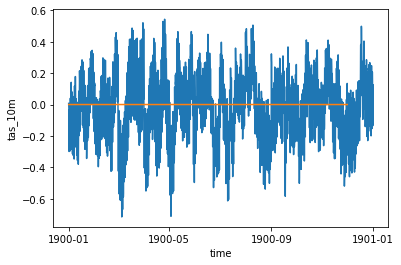

In [29]:
N34_JRA_RYF = ts.isel(longitude = slice(339,428)).isel(latitude = slice(150,169)).mean(['latitude','longitude']).load() # N34 region: 5°S-5°N and 170°W-120°W -> -5.335°S ... 5.335°S, 190.1°E ... 240.2°E
N34_JRA_RYF.plot()
N34_JRA_RYF.resample(time="1MS").mean(dim="time").plot()

### Plotting routine

CPU times: user 1.74 s, sys: 144 ms, total: 1.88 s
Wall time: 1.7 s


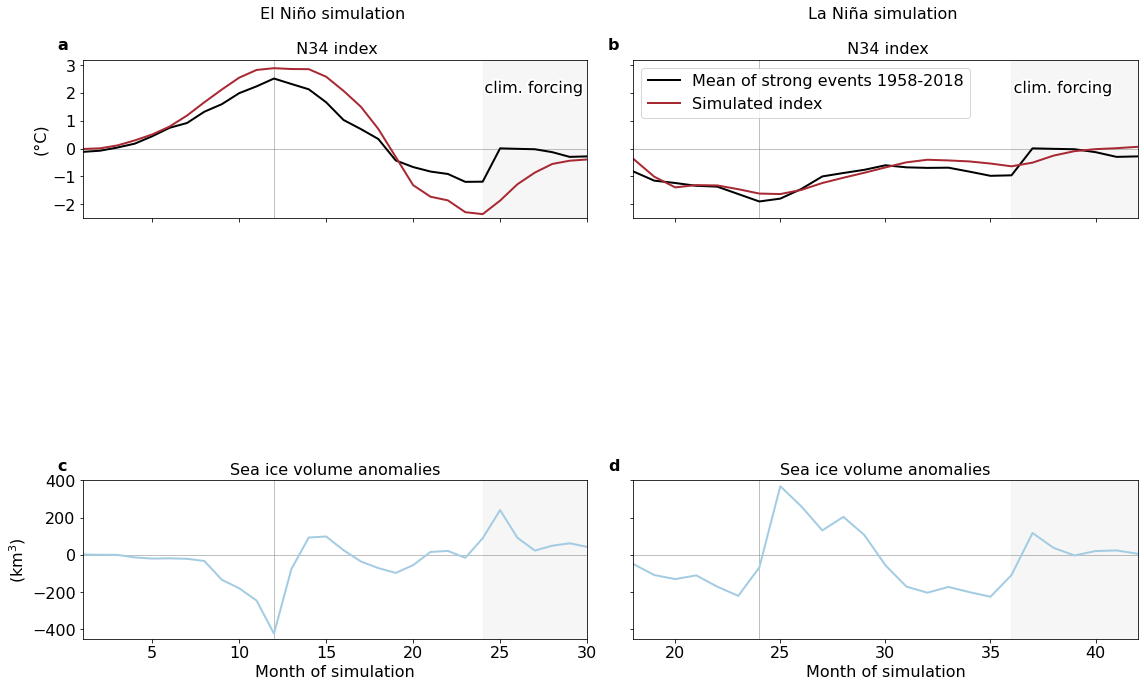

In [30]:
%%time
filename= 'Comparison_simulated_N34_and_JRA55-do'
stand = 0
time_EN = np.linspace(1,len(N34_EN01_anom),len(N34_EN01_anom)) # time axis of ENFull
time_LN = np.linspace(1,len(N34_LN01_anom),len(N34_LN01_anom)) # time axis of LNFull
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(16,12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,2, width_ratios=[1,1], height_ratios=[1,1,1,1]) 
event = ['El Niño', 'La Niña']
      
EN_mean = np.zeros(24+6); LN_mean = np.zeros(24+24)
for i in range(24+6):
    EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
for i in range(24+24):
    LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
EN_mean[-6:] = N34_JRA_RYF[0:6]
LN_mean[36:42] = N34_JRA_RYF[0:6]

for f in [0,1,4,5]:
    # JRA55 mean event N34 vs. simulated N34
    # ------------------------------------------------------------------- #
    if f == 0:
        ax1 = plt.subplot(gs[0,0]); plt.axvline(12, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'El Niño simulation \n\n N34 index'
        
        # EN_mean_long = np.pad(EN_mean, (0, 30-len(EN_mean)), "constant", constant_values=0) # append array with zeros until it reaches certain length
        plt.plot(np.linspace(1,len(EN_mean),len(EN_mean)), EN_mean, c = 'k', linewidth=2)
        plt.plot(time_EN, N34_EN01_anom, linewidth=2, color=rotblau[3])
    if f == 1:
        ax1 = plt.subplot(gs[0,1]); plt.axvline(24, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'La Niña simulation \n\n N34 index'

        plt.plot(np.linspace(1,len(LN_mean),len(LN_mean)), LN_mean, linewidth=2, c = 'k', label = 'Mean of strong events 1958-2018')
        plt.plot(time_LN, N34_LN01_anom, linewidth=2, color=rotblau[3], label = 'Simulated index')

    # poleward Ekman transports 
    # ------------------------------------------------------------------- # 
    if f == 2:
        ax1 = plt.subplot(gs[1,0]); plt.axvline(12, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Poleward Ekman transport anomalies \nat the 1000 m isobath location'
        
        plt.plot(time_EN, poleward_Ekman_EN, linewidth=2, color=rotblau[6])
        
    if f == 3:
        ax1 = plt.subplot(gs[1,1]); plt.axvline(24, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Poleward Ekman transport anomalies \nat the 1000 m isobath location'

        plt.plot(time_LN, poleward_Ekman_LN, linewidth=2, color=rotblau[6]) 
          

    # simulated sea ice volume anomalies
    # ------------------------------------------------------------------- #  
    if f == 4: 
        ax1 = plt.subplot(gs[2,0]); plt.axhline(0, c = 'grey', linewidth=.5); plt.axvline(12, c = 'grey', linewidth=.5)
        time = np.linspace(1,len(temp_tendency_EN_100_down), len(temp_tendency_EN_100_down)); title_str = 'Sea ice volume anomalies'
        plt.plot(time, vi_con_EN_anom,                                                      label = 'vicen_m',      linewidth = 2, color = rotblau[13])
        
    if f == 5: 
        ax1 = plt.subplot(gs[2,1]); plt.axhline(0, c = 'grey', linewidth=.5); plt.axvline(24, c = 'grey', linewidth=.5)
        time = np.linspace(1,len(temp_tendency_LN_100_down), len(temp_tendency_LN_100_down)); title_str = 'Sea ice volume anomalies'
        plt.plot(time, vi_con_LN_anom,                                                      label = 'vicen_m',      linewidth = 2, color = rotblau[13])    
    
    # simulated temperature anomalies 
    # ------------------------------------------------------------------- # 
    if f == 6:
        ax1 = plt.subplot(gs[3,0]); plt.axvline(12, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Sea level anomalies'
        
        plt.plot(time_EN, sea_level_EN_anom, linewidth=2, color=rotblau[18])
        
    if f == 7:
        ax1 = plt.subplot(gs[3,1]); plt.axvline(24, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Sea level anomalies'

        plt.plot(time_LN, sea_level_LN_anom, linewidth=2, color=rotblau[18]) 

    # specifics about the subplots
    if f in [0,2,4,6]: plt.xlim([ 1,30]); ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # axis limit & shade period where I applied climatological, RYF, forcing
    if f in [1,3,5,7]: plt.xlim([18,42]); ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) 
    
    if f in [0]: ax1.text(24.1, 2, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [1]: 
        plt.legend(fontsize=16, loc='upper left') # add legend to N34 index panel where I have two time series
        ax1.text(36.1, 2, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    
    if f in [0,1]: plt.ylim([-2.5,3.2])
    if f in [2,3]: plt.ylim([-.5,1]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
    if f in [4,5]: plt.ylim([-450,400])
    if f in [6,7]: plt.ylim([-.015, .015]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
    
    if f == 0: ax1.set_ylabel('(°C)', color='k', fontsize=16)
    if f == 2: ax1.set_ylabel('(Sv)', color='k', fontsize=16)
    if f == 4: ax1.set_ylabel('(km$^{3}$)', color='k', fontsize=16)
    if f == 6: ax1.set_ylabel('(m)', color='k', fontsize=16)
    
    if f in [0,1,2,3]: ax1.set_xticklabels([]); ax1.set(xlabel=None) # no x axis ticks and labels
    if f in [1,3,5,7]: ax1.set_yticklabels([]); ax1.set(ylabel=None) # no x axis ticks and labels

    plt.title(title_str, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    if f in [0,1]:ax1.text(-.05, 1.06, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    if f in [4,5]:ax1.text(-.05, 1.06, string.ascii_lowercase[f-2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    if f in [4,5]: ax1.set_xlabel('Month of simulation', color='k', fontsize=16) # x-axis label
    if f in [6]: ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 
    if f in [7]: ax1.set_xticks([18, 24, 30, 36, 42])

    # fig.legend(ncol=2, fontsize=16, bbox_to_anchor=(.5, -.25), loc='lower center')
# --- saving as 300 dpi .PNG image in specified folder --------------- #
plt.savefig(save + filename+'_slp_winds_only', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,    #
            format=None, transparent=False, bbox_inches='tight',       #
            pad_inches=0.1, metadata=None)                             #
# --- end of script -------------------------------------------------- # 
# Wall time: 2.14 s

### Save the time series as a pandas dataframe .txt file

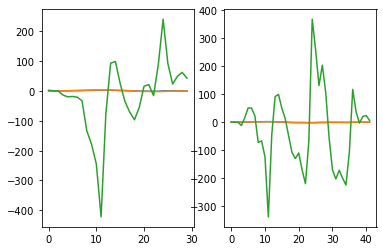

In [31]:
# create pandas dataframe and save it
for f in range(2): # loop through the EN and LN panels and create two pandas dataframes
    if f == 0: ts1 = EN_mean; ts2 = N34_EN01_anom; ts3 = vi_con_EN_anom; suffix = '_EN'
    if f == 1: ts1 = LN_mean[0:42]; ts2 = N34_LN01_anom; ts3 = vi_con_LN_anom; suffix = '_LN'
    
    d = {'Composite_N34_index': ts1, 'Simulated_N34_index': ts2, 'Sea_ice_volume_anoms': ts3}; df = pd.DataFrame(data=d)
    df.to_csv('/g/data/e14/mv7494/ENSOAnt_data/FigS11_Time_Series_N34_index_and_Sea_Ice_Volume_anoms' + suffix + '.txt', sep='\t', index=False) # saving the data frame
    plt.subplot(1,2,f+1); plt.plot(df) # to check if all okay

### Convert time series in panels (a) and (b) to heat content instead of temperature only

In [32]:
rho_0 = 1035.0                       # [kg m^{-3}]
C_p   = 3992.10322329649               # [J kg^{-1} K^{-1}]
# OHC_ts_EN = rho_0 * C_p * anom_EN_WA_1001000 * ((area_t * dzt)*above1000_tcells).sum(['yt_ocean', 'xt_ocean', 'st_ocean']).load()
# OHC_ts_LN = rho_0 * C_p * anom_LN_WA_1001000 * ((area_t * dzt)*above1000_tcells).sum(['yt_ocean', 'xt_ocean', 'st_ocean']).load()
# plt.plot(OHC_ts_EN, label='EN'); plt.plot(OHC_ts_LN, label='LN'); plt.legend()

OHC_ts_EN = temp_tendency_EN_100_down.cumsum('time').load()
OHC_ts_LN = temp_tendency_LN_100_down.cumsum('time').load() # this is a much cleaner way instead of calculating rho_0*Cp*Theta*V


# toggle to plot the figure either with (a) temperature anomalies or (b) heat content anomalies #
heat = 'on' # 'off'
# --------------------------------------------------------------------------------------------- #

plotting heat content anomalies in panel (a) and panel (b)
CPU times: user 2.64 s, sys: 246 ms, total: 2.88 s
Wall time: 2.64 s


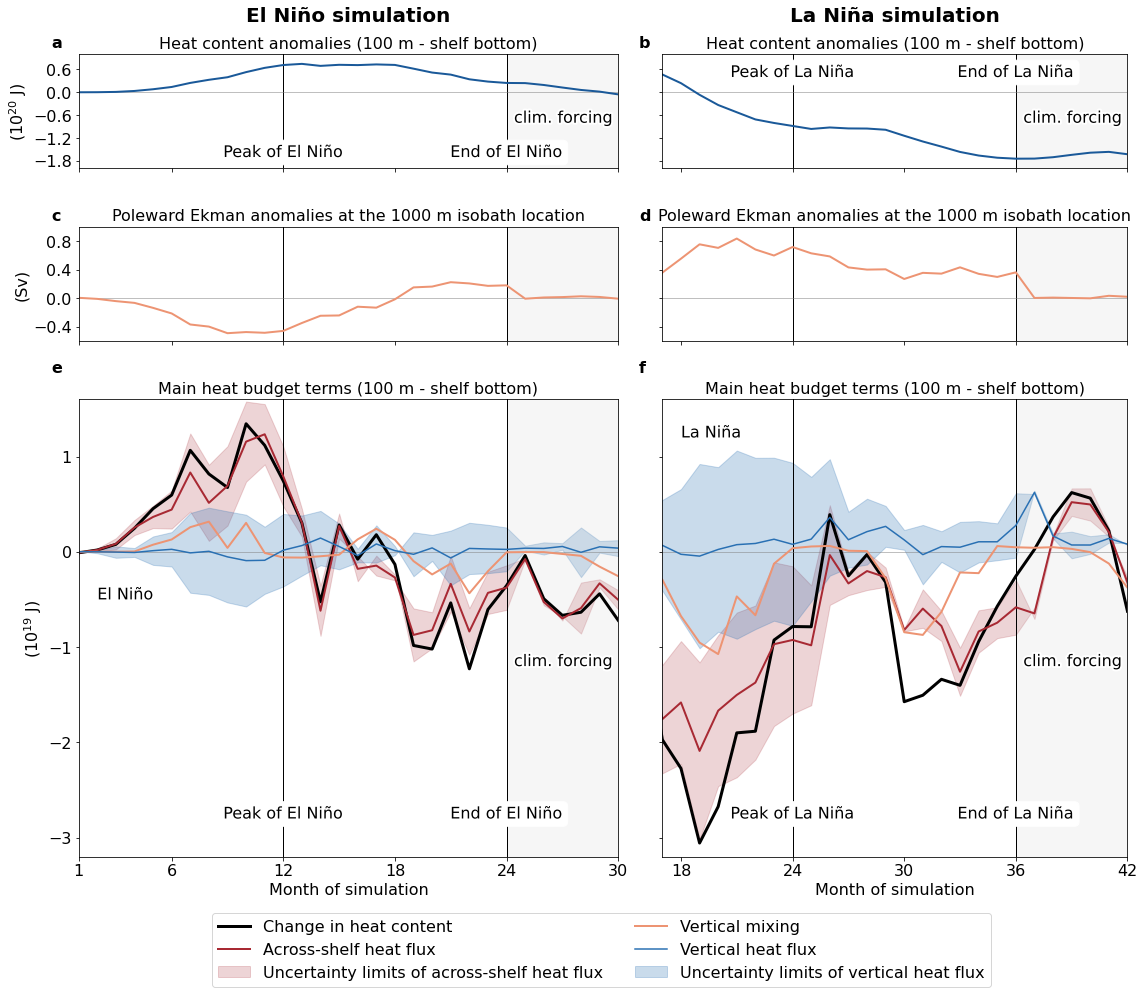

In [33]:
%%time
filename= 'Comparison_simulated_N34_and_JRA55-do'
stand = 0
time_EN = np.linspace(1,len(N34_EN01_anom),len(N34_EN01_anom)) # time axis of ENFull
time_LN = np.linspace(1,len(N34_LN01_anom),len(N34_LN01_anom)) # time axis of LNFull
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(16,16),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,2, width_ratios=[29,25], height_ratios=[1,.5,.5,2]) 
event = ['El Niño', 'La Niña']
 
if heat == 'on':
    print('plotting heat content anomalies in panel (a) and panel (b)')
    panel_titel = 'Heat content anomalies (100 m - shelf bottom)'
    ts_EN = OHC_ts_EN / 1e20
    ts_LN = OHC_ts_LN / 1e20
    ylimite = [-2,1]; ybeschriftung = '(10$^{20}$ J)'; dateiname = 'heat'
    
if heat == 'off':
    print('plotting temperature anomalies in panel (a) and panel (b)')
    panel_titel = 'Mean shelf temperatures (100 m - shelf bottom)'
    ts_EN = anom_EN_WA_1001000
    ts_LN = anom_LN_WA_1001000   
    ylimite = [-.15, .08];  ybeschriftung = '(°C)'; dateiname = 'temperature'
    
for f in [2,3,4,5,6,7]:
    # simulated temperature or heat content anomalies 
    # ------------------------------------------------------------------- # 
        

    if f == 2:
        ax1 = plt.subplot(gs[1,0]); plt.axvline(12, c = 'k', linewidth=1); plt.axvline(24, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = panel_titel
        # plt.plot(time_EN, anom_EN_AS, linewidth=2, color=rotblau[5])
        # plt.plot(time_EN, anom_EN_BS, linewidth=2, color=rotblau[15])
        
        plt.plot(time_EN, ts_EN, linewidth=2, color=rotblau[18]) # either heat content or temperature anomalies here
        plt.text(15.5,2,'El Niño simulation', fontsize=20, ha='center', va='center', fontweight='bold') # x0, y0
    if f == 3:
        ax1 = plt.subplot(gs[1,1]); plt.axvline(24, c = 'k', linewidth=1); plt.axvline(36, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = panel_titel
        # plt.plot(time_LN, anom_LN_AS, linewidth=2, color=rotblau[5], label = 'Amundsen Sea')
        # plt.plot(time_LN, anom_LN_BS, linewidth=2, color=rotblau[15], label = 'Bellingshausen Sea')

        plt.plot(time_LN, ts_LN, linewidth=2, color=rotblau[18]) 
        
        plt.text(29.5,2,'La Niña simulation', fontsize=20, ha='center', va='center', fontweight='bold') # x0, y0
    
    if f == 4:
        ax1 = plt.subplot(gs[2,0]); plt.axvline(12, c = 'k', linewidth=1); plt.axvline(24, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Poleward Ekman anomalies at the 1000 m isobath location'
        plt.plot(time_EN, poleward_Ekman_EN, linewidth=2, color=rotblau[6]) 
        plt.ylabel('(Sv)', fontsize=16)
    if f == 5:
        ax1 = plt.subplot(gs[2,1]); plt.axvline(24, c = 'k', linewidth=1); plt.axvline(36, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Poleward Ekman anomalies at the 1000 m isobath location'
        plt.plot(time_LN, poleward_Ekman_LN, linewidth=2, color=rotblau[6]) 

    # simulated heat budget terms
    # ------------------------------------------------------------------- #         
    if f == 6:
        ax1 = plt.subplot(gs[3,0]); plt.axvline(12, c = 'k', linewidth=1); plt.axvline(24, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Main heat budget terms (100 m - shelf bottom)'

        time = np.linspace(1,len(temp_tendency_EN_100_down), len(temp_tendency_EN_100_down))
        
        temp_tendency_sfc1000 = temp_tendency_EN_sfc_down;        temp_submeso_sfc1000 = temp_submeso_EN_sfc_down;        temp_vdiffuse_sbc_sfc1000 = temp_vdiffuse_sbc_EN_sfc_down
        sw_heat_sfc1000 = sw_heat_EN_sfc_down;        temp_eta_smooth_sfc1000 = temp_eta_smooth_EN_sfc_down;        frazil_3d_sfc1000 = frazil_3d_EN_sfc_down
        
        temp_submeso = temp_submeso_EN_100_down; temp_tendency = temp_tendency_EN_100_down; temp_advection = temp_advection_EN_100_down; temp_vdiffuse_diff_cbt = temp_vdiffuse_diff_cbt_EN_100_down
        temp_nonlocal_KPP = temp_nonlocal_KPP_EN_100_down; sw_heat = sw_heat_EN_100_down; temp_vdiffuse_sbc = temp_vdiffuse_sbc_EN_100_down; sfc_hflux_pme = sfc_hflux_pme_EN_100_down
        frazil_3d = frazil_3d_EN_100_down; temp_eta_smooth = temp_eta_smooth_EN_100_down; temp_rivermix = temp_rivermix_EN_100_down
        
    if f == 7:
        ax1 = plt.subplot(gs[3,1]); plt.axvline(24, c = 'k', linewidth=1); plt.axvline(36, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Main heat budget terms (100 m - shelf bottom)'
        
        time = np.linspace(1,len(temp_tendency_LN_100_down), len(temp_tendency_LN_100_down))
        
        temp_tendency_sfc1000 = temp_tendency_LN_sfc_down;        temp_submeso_sfc1000 = temp_submeso_LN_sfc_down;        temp_vdiffuse_sbc_sfc1000 = temp_vdiffuse_sbc_LN_sfc_down
        sw_heat_sfc1000 = sw_heat_LN_sfc_down;        temp_eta_smooth_sfc1000 = temp_eta_smooth_LN_sfc_down;        frazil_3d_sfc1000 = frazil_3d_LN_sfc_down
        
        temp_submeso = temp_submeso_LN_100_down; temp_tendency = temp_tendency_LN_100_down; temp_advection = temp_advection_LN_100_down; temp_vdiffuse_diff_cbt = temp_vdiffuse_diff_cbt_LN_100_down
        temp_nonlocal_KPP = temp_nonlocal_KPP_LN_100_down; sw_heat = sw_heat_LN_100_down; temp_vdiffuse_sbc = temp_vdiffuse_sbc_LN_100_down; sfc_hflux_pme = sfc_hflux_pme_LN_100_down
        frazil_3d = frazil_3d_LN_100_down; temp_eta_smooth = temp_eta_smooth_LN_100_down; temp_rivermix = temp_rivermix_LN_100_down

    if f in [6, 7]:
        plt.plot(time, temp_tendency/1e19,                                                      label = 'Change in heat content',      linewidth = 3, color = 'k')
        # plt.plot(time, temp_advection/1e19,                                                     label = 'Heat transport convergence', linewidth = 3, color = rotblau[1])

    # adding the vertical heat fluxes and uncertainties
    if f == 6:
        across       = temp_advection - (vertical_heat_flux_EN + along_shelf_heat_flux_EN)
        across_lower = temp_advection - ((vertical_heat_flux_EN+vertical_heat_flux_uncertainty_EN) + (along_shelf_heat_flux_EN+along_shelf_heat_flux_uncertainty_EN))
        across_upper = temp_advection - ((vertical_heat_flux_EN-vertical_heat_flux_uncertainty_EN) + (along_shelf_heat_flux_EN-along_shelf_heat_flux_uncertainty_EN))
        
        plt.plot(time, across/1e19, label = 'Across-shelf heat flux', linewidth = 2, color = rotblau[3])
        ax1.fill_between(time, across_upper/1e19, across_lower/1e19,  color= rotblau[3], alpha=.2, label= 'Uncertainty limits of across-shelf heat flux')
          
        plt.plot(time, (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP)/1e19,                         label = 'Vertical mixing',            linewidth = 2, color = rotblau[6]) 
        
        plt.plot(time, vertical_heat_flux_EN/1e19, label = 'Vertical heat flux', c=rotblau[17]);
        ax1.fill_between(time, (vertical_heat_flux_EN+vertical_heat_flux_uncertainty_EN)/1e19, 
                         (vertical_heat_flux_EN-vertical_heat_flux_uncertainty_EN)/1e19,  color=rotblau[17], alpha=.25, label= 'Uncertainty limits of vertical heat flux')

    if f == 7:
        across       = (temp_advection - vertical_heat_flux_LN - along_shelf_heat_flux_LN)
        across_lower = (temp_advection - (vertical_heat_flux_LN+vertical_heat_flux_uncertainty_LN) - (along_shelf_heat_flux_LN+along_shelf_heat_flux_uncertainty_LN))
        across_upper = (temp_advection - (vertical_heat_flux_LN-vertical_heat_flux_uncertainty_LN) - (along_shelf_heat_flux_LN-along_shelf_heat_flux_uncertainty_LN))
        
        plt.plot(time, across/1e19, linewidth = 2, color = rotblau[3])
        ax1.fill_between(time, across_upper/1e19, across_lower/1e19,  color= rotblau[3], alpha=.2)
          
        plt.plot(time, (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP)/1e19,                         label = 'Vertical mixing',            linewidth = 2, color = rotblau[6]) 
    
        plt.plot(time, vertical_heat_flux_LN/1e19, label = 'Vertical heat flux', c=rotblau[17]);
        ax1.fill_between(time, (vertical_heat_flux_LN+vertical_heat_flux_uncertainty_LN)/1e19, 
                         (vertical_heat_flux_LN-vertical_heat_flux_uncertainty_LN)/1e19,  color=rotblau[17], alpha=.25)

    ax1.tick_params(axis='y', labelcolor='k')
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        
    if f == 6:
        plt.title('El Niño', fontsize=16)
        ax1.set_ylabel('(10$^{19}$ J)', color='k', fontsize=16) # hide x-axis label
    if f == 7:
        plt.title('La Niña', fontsize=16)
        ax1.set_yticklabels([]); ax1.set(ylabel=None) 

    if f in [6]: 
        # plot only one legend for the two panels
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, fontsize=16, ncol=2, bbox_to_anchor=(.525, -.075), loc='lower center')

    # specifics for only certain subplots
    if f <= 5:  ax1.set_xticklabels([]); ax1.set(xlabel=None)
    if f in [2]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 
    if f in [1,3,5,7]: # specifics for La Niña panels on the right
        plt.xlim([17, 42]); ax1.set_xticks([18, 24, 30, 36, 42]); ax1.set_yticklabels([]); # ax1.set_xticks([18, 24, 30, 36]); 

    if f in [2]: plt.ylabel(ybeschriftung, fontsize=16) # y-axis label 
    # set axis limits
    if f in [2,3]: plt.ylim([ylimite[0], ylimite[1]]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
    if f in [4,5]: plt.ylim([-.6,1]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
   
    if f in [0]: plt.ylabel('(°C)', fontsize=16) # titles
    if f <= 3:  ax1.set_xticklabels([]); ax1.set_xlabel(None)
    if f in [0,2,4, 6]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 

    if f in [7]: # specifics for La Niña panels on the right
        plt.xlim([17, 42]); ax1.set_xticks([18, 24, 30, 36, 42]); ax1.set_yticklabels([]); # ax1.set_xticks([18, 24, 30, 36]); 

    if f in [2,4,6]: ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing
    if f in [3,5,7]: ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

    # annotations
    if f in [2]: 
        ax1.text(12, -1.7, 'Peak of El Niño', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24, -1.7, 'End of El Niño', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24.4, -.8, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [3]: 
        ax1.text(24, .4, 'Peak of La Niña', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36, .4, 'End of La Niña', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36.4, -.8, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        # ax1.annotate('', xy=(27, -2.6), xytext=(24.1, -2.6),xycoords='data', size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy"))
    if f in [6]: 
        ax1.text(12, -2.8, 'Peak of El Niño', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24, -2.8, 'End of El Niño', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24.4, -1.2, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [7]: 
        ax1.text(24, -2.8, 'Peak of La Niña', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36, -2.8, 'End of La Niña', fontsize=16, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36.4, -1.2, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        # ax1.annotate('', xy=(27, -2.6), xytext=(24.1, -2.6),xycoords='data', size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy"))
        
    
    
    if f in [6, 7]: 
        ax1.set_xlabel('Month of simulation', color='k', fontsize=16) # x-axis label
        plt.ylim([-3.2,1.6])
    if f == 6:
        ax1.text(2, -.5, 'El Niño', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f == 7:
        ax1.text(18, 1.2, 'La Niña', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
                        
    # specifics for all subplots
    plt.title(title_str, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    ax1.text(-.05, 1.06, string.ascii_lowercase[f-2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
    # Save the data in a pandas dataframe

    if f == 6: 
        ts1 = ts_EN
        # ts2 = poleward_Ekman_EN
        ts3 = temp_tendency/1e19
        ts4 = across/1e19
        ts5 = across_lower/1e19
        ts6 = across_upper/1e19
        ts7 = (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP)/1e19
        ts8 = vertical_heat_flux_EN/1e19
        ts9 = (vertical_heat_flux_EN-vertical_heat_flux_uncertainty_EN)/1e19
        ts10 = (vertical_heat_flux_EN+vertical_heat_flux_uncertainty_EN)/1e19
        suffix = '_EN'; panel_letter = 'c'
    if f == 7: 
        ts1 = ts_LN
        # ts2 = poleward_Ekman_LN
        ts3 = temp_tendency/1e19
        ts4 = across/1e19
        ts5 = across_lower/1e19
        ts6 = across_upper/1e19
        ts7 = (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP)/1e19
        ts8 = vertical_heat_flux_LN/1e19
        ts9 = (vertical_heat_flux_LN-vertical_heat_flux_uncertainty_LN)/1e19
        ts10 = (vertical_heat_flux_LN+vertical_heat_flux_uncertainty_LN)/1e19
        suffix = '_LN'; panel_letter = 'd'
    if f in [6, 7]:
        ds3 = xr.Dataset({'Heat_content_anoms': (('time'), ts1.values), 
             # 'Poleward_Ekman_anoms': (('time'), ts2.values), 
             'Heat_content_tendency': (('time'), ts3.values),  
             'Across_shelf_heat_flux': (('time'), ts4.values), 
             'Lower_limit_across_shelf_heat_flux': (('time'), ts5.values),  
             'Upper_limit_across_shelf_heat_flux': (('time'), ts6.values),  
             'Vertical_mixing': (('time'), ts7.values), 
             'Vertical_heat_flux': (('time'), ts8.values), 
             'Lower_limit_vertical_heat_flux': (('time'), ts9.values), 
             'Upper_limit_vertical_heat_flux': (('time'), ts10.values)},
                         attrs=dict(Project = 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                                    Author = 'Maurice F. Huguenin', 
                                    Created = '2023-06-14', 
                                    Mail = 'm.huguenin-virchaux@unsw.edu.au', 
                                    Funding = 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'))
        ds3.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/Fig3_Heat_Content_Ekman_anoms_and_Heat_Budget_Time_series' + suffix + '.nc')
        # plt.plot(ds3) # to check if all okay

# fig.legend(ncol=2, fontsize=16, bbox_to_anchor=(.5, -.25), loc='lower center')
# --- saving as 300 dpi .PNG image in specified folder --------------- #
plt.savefig(save + filename+'_slp_winds_only_heat_budget_with_added_top_panels_'+dateiname, dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,    #
            format=None, transparent=False, bbox_inches='tight',       #
            pad_inches=0.1, metadata=None)                             #
# --- end of script -------------------------------------------------- # 
# Wall time: 2.14 s

### Checking if time derivative of OHC*rho_0*C_p*volume = temp_advection

CPU times: user 673 ms, sys: 66.5 ms, total: 740 ms
Wall time: 1.2 s


Text(0.5, 1.0, 'above1000_tcells mask')

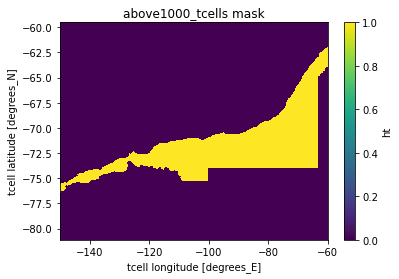

In [34]:
%%time
ds = xr.open_mfdataset('/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_LNFull_transport/output976/ocean/ocean_heat.nc')
field = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc').ht
bath_mask = xr.where(field.isel(xt_ocean=slice(1299,2200),yt_ocean=slice(0,500))<=1000,1,0)

bath_mask[:396,886:] = bath_mask[:396,886:].where(bath_mask[:396,886:]!=1, 0) # manually mask out all the other sea mounts and the region
bath_mask[:170,500:] = bath_mask[:170,500:].where(bath_mask[:170,500:]!=1, 0) # in the western Weddell Sea
bath_mask[270:,:670] = bath_mask[270:,:670].where(bath_mask[270:,:670]!=1, 0)
bath_mask[410:,:840] = bath_mask[410:,:840].where(bath_mask[410:,:840]!=1, 0)
bath_mask[:390,878:] = bath_mask[:390,878:].where(bath_mask[:390,878:]!=1, 0)

# and also unmasking the grid cells that are seamounts on the shelf
bath_mask[145:160,100:120] = bath_mask[145:160,100:120].where(bath_mask[145:160,100:120]!=0, 1)
bath_mask[169:175,313:333] = bath_mask[169:175,313:333].where(bath_mask[169:175,313:333]!=0, 1)
bath_mask[175:210,313:400] = bath_mask[175:210,313:400].where(bath_mask[175:210,313:400]!=0, 1)
bath_mask[166:225,340:351] = bath_mask[166:225,340:351].where(bath_mask[166:225,340:351]!=0, 1)
bath_mask[139:225,410:500] = bath_mask[139:225,410:500].where(bath_mask[139:225,410:500]!=0, 1)
bath_mask[170:220,620:790] = bath_mask[170:220,620:790].where(bath_mask[170:220,620:790]!=0, 1)
bath_mask[200:287,720:870] = bath_mask[200:287,720:870].where(bath_mask[200:287,720:870]!=0, 1)
bath_mask[270:310,760:870] = bath_mask[270:310,760:870].where(bath_mask[270:310,760:870]!=0, 1)
bath_mask[300:345,785:870] = bath_mask[300:345,785:870].where(bath_mask[300:345,785:870]!=0, 1)
bath_mask[340:380,815:870] = bath_mask[340:380,815:870].where(bath_mask[340:380,815:870]!=0, 1)
bath_mask[340:410,855:870] = bath_mask[340:410,855:870].where(bath_mask[340:410,855:870]!=0, 1)
bath_mask[389:425,868:874] = bath_mask[389:425,868:874].where(bath_mask[389:425,868:874]!=0, 1)
bath_mask[393:425,868:884] = bath_mask[393:425,868:884].where(bath_mask[393:425,868:884]!=0, 1)
bath_mask[400:425,868:890] = bath_mask[400:425,868:890].where(bath_mask[400:425,868:890]!=0, 1)
bath_mask[407:438,873:] = bath_mask[407:438,873:].where(bath_mask[407:438,873:]!=0, 1)
bath_mask[407:445,890:] = bath_mask[407:445,890:].where(bath_mask[407:445,890:]!=0, 1)
bath_mask[170:230,490:870] = bath_mask[170:230,490:870].where(bath_mask[170:230,490:870]!=0, 1)
above1000_tcells = bath_mask; above1000_tcells.plot(); plt.title('above1000_tcells mask')
# # Wall time: 51.6 s

In [35]:
(rho_0 * C_p * temp_EN_anom_full_depth.differentiate('time') * volume).sum(['st_ocean', 'yt_ocean', 'xt_ocean']).plot()

NameError: name 'volume' is not defined

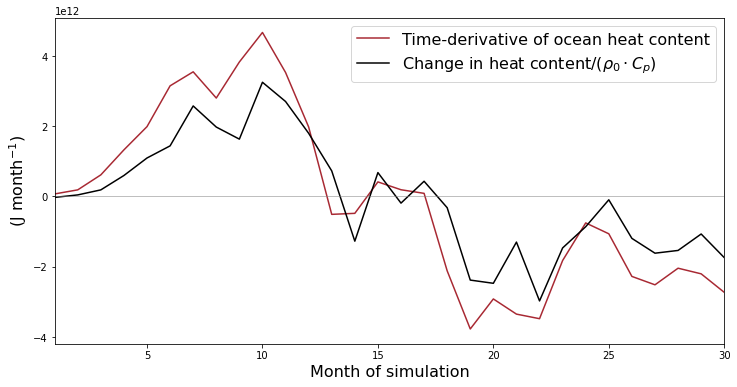

In [48]:
plt.figure(figsize=(12,6))
time = np.linspace(1,30,30)
volume = (area_t[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]*ht*above1000_tcells).sum(['yt_ocean', 'xt_ocean']).values
plt.plot(time, (OHC_ts_EN).differentiate('time'), c = rotblau[3], label='Time-derivative of ocean heat content')
plt.plot(time, temp_tendency_EN_100_down/(rho_0*C_p), c='k', label='Change in heat content'+ r'$ / (\rho_0 \cdot C_p)$')
plt.ylabel('(J month$^{-1}$)', fontsize=16); plt.axhline(0, lw=.5, c='grey')
plt.xlabel('Month of simulation', fontsize=16)
plt.xlim([1,30])
plt.legend(fontsize=16)

### Same plot as for (g, h) above but for the surface to 1000 m depth

CPU times: user 1.23 s, sys: 89.5 ms, total: 1.32 s
Wall time: 1.21 s


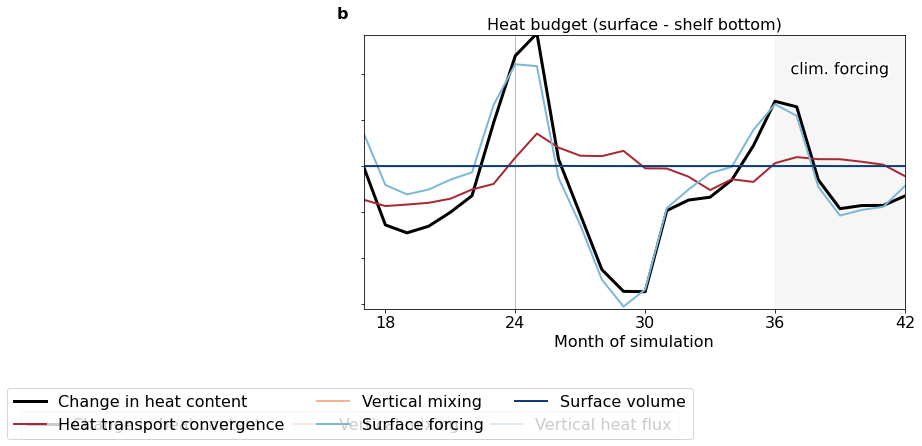

In [35]:
%%time
filename= 'Comparison_simulated_N34_and_JRA55-do'
stand = 0
time_EN = np.linspace(1,len(N34_EN01_anom),len(N34_EN01_anom)) # time axis of ENFull
time_LN = np.linspace(1,len(N34_LN01_anom),len(N34_LN01_anom)) # time axis of LNFull
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(16,12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,2, width_ratios=[1,1], height_ratios=[1,1,1,2]) 
event = ['El Niño', 'La Niña']
      
EN_mean = np.zeros(24+6); LN_mean = np.zeros(24+24)
for i in range(24+6):
    EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
for i in range(24+24):
    LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
    
for f in [6,7]:

    # simulated heat budget terms
    # ------------------------------------------------------------------- #         

    if f == 7:
        ax1 = plt.subplot(gs[3,1]); plt.axvline(24, c = 'grey', linewidth=.5); plt.axvline(12, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'Heat budget (surface - shelf bottom)'
        
        time = np.linspace(1,len(temp_tendency_LN_100_down), len(temp_tendency_LN_100_down))
        
        temp_tendency_sfc1000 = anom_LN_WA_sfc1000
        temp_submeso = temp_submeso_LN_sfc_down; temp_tendency = temp_tendency_LN_sfc_down; temp_advection = temp_advection_LN_sfc_down; temp_vdiffuse_diff_cbt = temp_vdiffuse_diff_cbt_LN_sfc_down
        temp_nonlocal_KPP = temp_nonlocal_KPP_LN_sfc_down; sw_heat = sw_heat_LN_sfc_down; temp_vdiffuse_sbc = temp_vdiffuse_sbc_LN_sfc_down; sfc_hflux_pme = sfc_hflux_pme_LN_sfc_down
        frazil_3d = frazil_3d_LN_sfc_down; temp_eta_smooth = temp_eta_smooth_LN_sfc_down; temp_rivermix = temp_rivermix_LN_sfc_down

    if f in [6, 7]:
        # plt.plot(time, temp_tendency_sfc1000,                                                  label = 'Heat content tendency surface - 1000 m',      linewidth = 2, color = rotblau[18], linestyle='--')
        plt.plot(time, temp_tendency/1e19,                                                      label = 'Change in heat content',      linewidth = 3, color = 'k')
        plt.plot(time, temp_advection/1e19,                                                     label = 'Heat transport convergence', linewidth = 2, color = rotblau[3])
        plt.plot(time, (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP)/1e19,                         label = 'Vertical mixing',            linewidth = 2, color = rotblau[7])
        plt.plot(time, (temp_submeso+temp_vdiffuse_sbc+sw_heat+temp_eta_smooth+frazil_3d+sfc_hflux_pme)/1e19, label = 'Surface forcing',            linewidth = 2, color = rotblau[14])
        plt.plot(time, temp_rivermix/1e19,                                                      label = 'Surface volume',             linewidth = 2, color = rotblau[19])

            # (sfc_hflux_pme          ).plot(label = 'sfc_hflux_pme', linewidth = 2)

        numerical = temp_tendency - (temp_submeso+temp_advection+temp_vdiffuse_diff_cbt+temp_nonlocal_KPP+sw_heat+temp_vdiffuse_sbc+
                         +frazil_3d+temp_eta_smooth+temp_rivermix)
        # plt.plot(time, numerical/1e6, label = 'Numerical mixing', linewidth = 2, linestyle='--')

        

        ax1.tick_params(axis='y', labelcolor='k')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        
    if f == 6:
        plt.title('El Niño', fontsize=16)
        ax1.set_ylabel('(10$^{19}$ J)', color='k', fontsize=16) # hide x-axis label
    if f == 7:
        plt.title('La Niña', fontsize=16)
        ax1.set_yticklabels([]); ax1.set(ylabel=None) 

    if f in [6, 7]: 
        # plot only one legend for the two panels
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, fontsize=16, ncol=3, bbox_to_anchor=(.5, -.1), loc='lower center')

    if f in [0,2,4, 6]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 
        ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

    if f in [1,3,5, 7]: # specifics for La Niña panels on the right
        plt.xlim([17, 42]); ax1.set_xticks([18, 24, 30, 36, 42]); ax1.set_yticklabels([]); # ax1.set_xticks([18, 24, 30, 36]); 
        ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

    if f in [6, 7]: 
        ax1.set_xlabel('Month of simulation', color='k', fontsize=16) # x-axis label
        # plt.ylim([-1.3,1.4])
        
    if f in [6]: ax1.text(27, 4, 'clim. forcing', fontsize=16, ha='center').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [7]: ax1.text(39, 4, 'clim. forcing', fontsize=16, ha='center').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    
    # specifics for all subplots
    plt.title(title_str, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)  
    ax1.text(-.05, 1.06, string.ascii_lowercase[f-6], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.ylim([-6.2,5.7])

    
# fig.legend(ncol=2, fontsize=16, bbox_to_anchor=(.5, -.25), loc='lower center')
# --- saving as 300 dpi .PNG image in specified folder --------------- #
plt.savefig(save + filename+'_slp_winds_only_surface_down', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,    #
            format=None, transparent=False, bbox_inches='tight',       #
            pad_inches=0.1, metadata=None)                             #
# --- end of script -------------------------------------------------- # 
# Wall time: 2.14 s

Check  if time-integrated tendency = anomalies

Text(0, -0.25, 'okay, because in right panel I show temp anoms instead of heat anoms\n I would need to calculate \rho_0*C_p*temp*V for a correct analysis \n but since these are all constants it is okay')

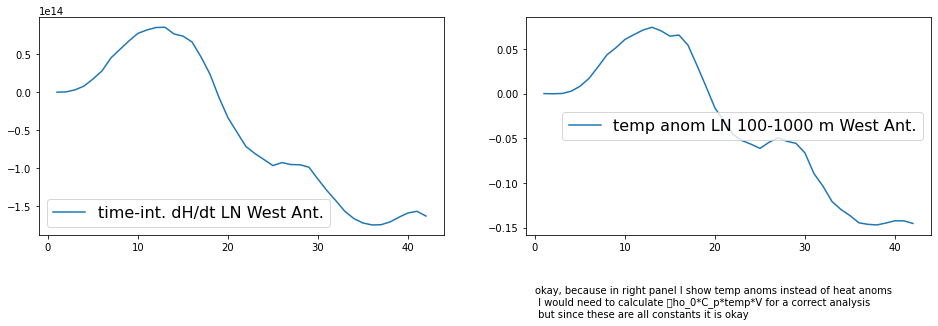

In [36]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1); plt.plot(time,(temp_tendency_LN_100_down/1e6).cumsum('time'), label='time-int. dH/dt LN West Ant.'); plt.legend(fontsize=16)
plt.subplot(1,2,2); plt.plot(time, anom_LN_WA, label= 'temp anom LN 100-1000 m West Ant.'); plt.legend(fontsize=16)

plt.text(0, -.25, 'okay, because in right panel I show temp anoms instead of heat anoms\n I would need to calculate \rho_0*C_p*temp*V for a correct analysis \n but since these are all constants it is okay')


In [37]:
np.std(N34_JRA)

<xarray.DataArray 'ts' ()>
array(0.8415457)

### Plotting the cumulative sum of the warming and cooling anomalies

plotting heat content anomalies in panel (a) and panel (b)
CPU times: user 750 ms, sys: 115 ms, total: 865 ms
Wall time: 736 ms


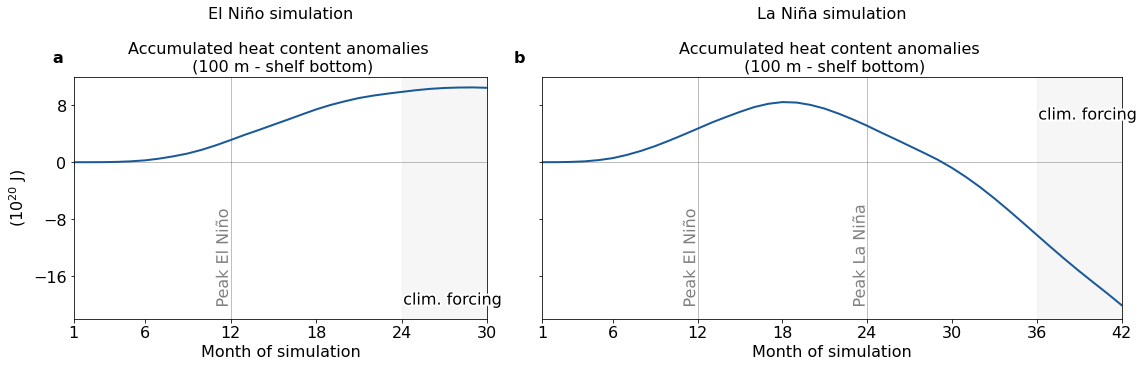

In [38]:
%%time
filename= 'Accumulated_temperature_anomalies_EN_and_LN_events_'
stand = 0
time_EN = np.linspace(1,len(N34_EN01_anom),len(N34_EN01_anom)) # time axis of ENFull
time_LN = np.linspace(1,len(N34_LN01_anom),len(N34_LN01_anom)) # time axis of LNFull
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(16,16),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,2, width_ratios=[30,42], height_ratios=[1,1,1.5,2]) 
event = ['El Niño', 'La Niña']
 
if heat == 'on':
    print('plotting heat content anomalies in panel (a) and panel (b)')
    panel_titel = 'Accumulated heat content anomalies \n (100 m - shelf bottom)'
    ts_EN = OHC_ts_EN.cumsum('time') / 1e20
    ts_LN = OHC_ts_LN.cumsum('time') / 1e20
    ylimite = [-22,12]; ybeschriftung = '(10$^{20}$ J)'; dateiname = 'heat'
    
if heat == 'off':
    print('plotting temperature anomalies in panel (a) and panel (b)')
    panel_titel = 'Accumulated mean shelf temperatures \n (100 m - shelf bottom)'
    ts_EN = anom_EN_WA_1001000.cumsum('time')
    ts_LN = anom_LN_WA_1001000.cumsum('time')   
    ylimite = [-.15, .08];  ybeschriftung = '(°C)'; dateiname = 'temperature'
    
for f in [2,3]:
    # simulated temperature or heat content anomalies 
    # ------------------------------------------------------------------- # 
        

    if f == 2:
        ax1 = plt.subplot(gs[2,0]); plt.axvline(12, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'El Niño simulation\n\n' + panel_titel
        # plt.plot(time_EN, anom_EN_AS, linewidth=2, color=rotblau[5])
        # plt.plot(time_EN, anom_EN_BS, linewidth=2, color=rotblau[15])
        
        plt.plot(time_EN, ts_EN, linewidth=2, color=rotblau[18]) # either heat content or temperature anomalies here
        
    if f == 3:
        ax1 = plt.subplot(gs[2,1]); plt.axvline(24, c = 'grey', linewidth=.5); plt.axvline(12, c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = 'La Niña simulation\n\n' + panel_titel
        # plt.plot(time_LN, anom_LN_AS, linewidth=2, color=rotblau[5], label = 'Amundsen Sea')
        # plt.plot(time_LN, anom_LN_BS, linewidth=2, color=rotblau[15], label = 'Bellingshausen Sea')

        plt.plot(time_LN, ts_LN, linewidth=2, color=rotblau[18])    


    # specifics for only certain subplots
    if f in [2]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 
    if f in [3]: # specifics for La Niña panels on the right
        plt.xlim([1, 42]); ax1.set_xticks([1,6,12,18, 24, 30, 36, 42]); ax1.set_yticklabels([]); # ax1.set_xticks([18, 24, 30, 36]); 

    if f in [2]: plt.ylabel(ybeschriftung, fontsize=16) # y-axis label 
    # set axis limits
    if f in [2,3]: plt.ylim([ylimite[0], ylimite[1]]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
   


    if f in [2,6]: ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing
    if f in [3,7]: ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

        
    if f in [2]: 
        ax1.text(24.1, -20, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        # ax1.annotate('', xy=(27, -2.6), xytext=(24.1, -2.6),xycoords='data', size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy"))
        ax1.text(11.5, -20, 'Peak El Niño', fontsize=16, ha='center', rotation=90, c='grey').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [3]: 
        ax1.text(36.1,   6, 'clim. forcing', fontsize=16, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        ax1.text(11.5, -20, 'Peak El Niño', fontsize=16, ha='center', rotation=90, c='grey').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        ax1.text(23.5, -20, 'Peak La Niña', fontsize=16, ha='center', rotation=90, c='grey').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    
    
    if f in [2,3]: 
        ax1.set_xlabel('Month of simulation', color='k', fontsize=16) # x-axis label
        
        
    # specifics for all subplots
    plt.title(title_str, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    if f in [2,3]:
        ax1.text(-.05, 1.06, string.ascii_lowercase[f-2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
# fig.legend(ncol=2, fontsize=16, bbox_to_anchor=(.5, -.25), loc='lower center')
# --- saving as 300 dpi .PNG image in specified folder --------------- #
plt.savefig(save + filename+dateiname, dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,    #
            format=None, transparent=False, bbox_inches='tight',       #
            pad_inches=0.1, metadata=None)                             #
# --- end of script -------------------------------------------------- # 
# Wall time: 2.14 s

# Looks good! Nice! 20230403_1027AEST

### Save the time series as a pandas dataframe .txt file

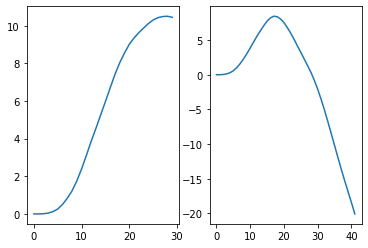

In [39]:
# create pandas dataframe and save it
for f in range(2): # loop through the EN and LN panels and create two pandas dataframes
    if f == 0: ts1 = ts_EN; suffix = '_EN'
    if f == 1: ts1 = ts_LN; suffix = '_LN'
    
    d = {'Accumulated_temperature_anomalies_' + suffix: ts1}; df = pd.DataFrame(data=d)
    df.to_csv('/g/data/e14/mv7494/ENSOAnt_data/FigS10_Accumulated_Temperature_anoms' + suffix + '.txt', sep='\t', index=False) # saving the data frame
    plt.subplot(1,2,f+1); plt.plot(df) # to check if all okay

In [40]:
df

,Accumulated_temperature_anomalies__LN
0,0.001555
1,0.006757
2,0.038869
3,0.120267
4,0.295449
5,0.576635
6,1.029898
7,1.595123
8,2.271166
9,3.046631


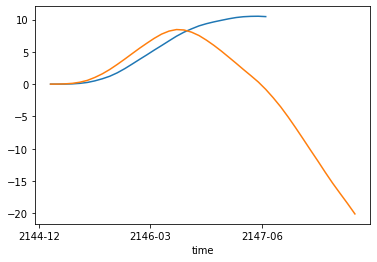

In [41]:
ts_EN.plot(); ts_LN.plot()

In [42]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #